# Image Classifier zur automatisierten Müllklassifizierung und Trennhilfe

**Modul:** 113451 Ausgewählte Anwendungen der KI (Selected Topics of AI) <br>
**Professor:** Prof. Dr. Johannes Maucher <br>
**Bearbeitet von:** Julia Ebert (je073), Lars Gerigk (lg107), Joel Starkov (js486) <br>
**Abgabe:** 28.01.2026 <br>

## Inhaltsverzeichnis

<table style="border:none; border-collapse:collapse">
  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#problemstellung" style="color:inherit; text-decoration:none;">
          1. Problemstellung und Zielsetzung
        </a>
      </b>
    </td>
    <td style="border:none; width:100%">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>1.1 Motivation und Problemanalyse</li>
        <li>1.2 Ziel
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>1.2.1 Zielunterscheidung</li>
          </ul>
        </li>
        <li>1.3 Fragestellungen</li>
        <li>1.4 Vorgehen</li>
        <li>1.5 Abgrenzung der Müllkategorien</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#installation" style="color:inherit; text-decoration:none;">
          2. Installation und Setup
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>2.1 Installation optional</li>
        <li>2.2 Imports</li>
        <li>2.3 Globale Konfigurationen und Utils
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>2.3.1 Reproduzierbarkeit</li>
            <li>2.3.2 Device Konfiguration</li>
            <li>2.3.3 Zentrale Hyperparameter Konfiguration</li>
            <li>2.3.4 Allgemeine Konfigurationen</li>
            <li>2.3.5 Konfigurationen der Modellarchitekturen</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#datensetanalyse" style="color:inherit; text-decoration:none;">
          3. Datensetanalyse
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>3.1 Herkunft der Daten
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>3.1.1 Externer Datensatz</li>
            <li>3.1.2 Eigener Datensatz</li>
          </ul>
        </li>
        <li>3.2 Datenintegration und manuelle Selektion</li>
        <li>3.3 Datenqualität</li>
        <li>3.4 Ausgangsstruktur der Daten</li>
        <li>3.5 Datenaufbereitung
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>3.5.1 Import der Bilder</li>
            <li>3.5.2 Bildverarbeitung in Trainings- und Validierungspartitionen</li>
            <li>3.5.1 Analyse der Klassenverteilung und Dateninspektion</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#modellarchitekturen" style="color:inherit; text-decoration:none;">
          4. Modellarchitekturen
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>4.1 Multi Layer Perceptron</li>
        <li>4.2 Convolutional Neural Network</li>
        <li>4.3 Transfer Learning
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>4.3.1 VGG16</li>
            <li>4.3.2 ResNet50</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#training" style="color:inherit; text-decoration:none;">
          5. Training & Testen
        </a>
      </b>
    </td>
    <td style="border:none">
      <ul style="margin:0; padding-left:18px; list-style-type:none;">
        <li>5.1 Funktionen</li>
        <li>5.2 Pipelines</li>
        <li>5.3 Hyperparameroptimierung mit Weights and Bias
          <ul style="margin:4px 0 0 18px; list-style-type:none;">
            <li>5.3.1 MLP - Hyperparameroptimierung</li>
            <li>5.3.2 CNN - Hyperparameroptimierung</li>
          </ul>
        </li>
      </ul>
    </td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#fazit" style="color:inherit; text-decoration:none;">
          6. Fazit
        </a>
      </b>
    </td>
    <td style="border:none"></td>
  </tr>

  <tr>
    <td style="vertical-align:top; border:none; white-space:nowrap; padding-right:20px;">
      <b>
        <a href="#quellen" style="color:inherit; text-decoration:none;">
          7. Quellen
        </a>
      </b>
    </td>
    <td style="border:none"></td>
  </tr>

</table>

**Hinweis:** Durch einen Klick auf die jeweilige Strukturebene im Inhaltsverzeichnis in der linken Spalte gelangt man direkt zur entsprechenden Stelle im Skript.


## 1. Problemstellung & Zielsetzung <a id="problemstellung"></a>

### 1.1. Motivation & Problemanalyse <a id="motivation"></a>

Die korrekte Trennung von Abfällen stellt für viele eine Herausforderung dar. Eine Umfrage von ALBA und Civey aus dem Jahr 2022 zeigt, dass nur 3,8% der Befragten Teilnehmer aus einer Stichprobengröße von 2.502 Menschen ihren Müll nicht trennen. Besonders hervorsticht, dass über 90% der Befragten, darauf achten Papier und Pappe vom Restmüll zu trennen. 87,3 % der Befragten trennen ihre Plastik(-verpackungen) vom Restmüll und 83,8 % trennen ihr Altglas vom Restmüll. Mit 64,4 % Müll trennen die Befragten am wenigsten von Biomüll und Restmüll. Diese Ergebnisse hören sich zunächst vielversprechend an. Allerdings täsuchen diese Ergebnisse, so der ALBA-Chef Eric Schweitzer. Eine Studie des Umweltbundesamtes zeigt auf, dass zwei Drittel des Inhalts der Restmülltonne, getrennt gesammelt und recycelt werden könnte. Zudem sagt Schweitzer aus, dass "Fehlerwürfe" von bis zu 30 Prozent keine Seltenheit ist. Somit werden Ressourcen folglich verbrannt, die die Gesamtkosten für Energie und die Produktion neuer Rohstoffe steigen für die Gesellschaft [1]. 

Fehlwürfe in der Mülltrennung lassen sich unter anderem auf ein fehlendes grundlegendes Verständnis des Abfalltrennungssystems sowie auf eine unzureichende und nicht einheitliche Aufklärung zurückführen. Die bestehenden Trennregeln sind teilweise komplex und unterscheiden sich je nach Region, was die korrekte Zuordnung einzelner Abfallarten erschwert. Durch die entstandenen Unsicherheiten führen in der Praxis zu erhöhten Fehlwürfen und beeinträchtigen die Effizienz von Recyclingprozessen [2].

Im Folgenden wird ein Anwendungsbeispiel für den Einsatz eines bildbasierten Klassifikationssystems an der Hochschule der Medien (kurz: HdM) vorgestellt. Ziel ist es, die Mülltrennung und damit die Recyclingqualität auf dem Campus zu verbessern. Zu diesem Zweck wird ein Image Classifier entwickelt, der anhand eines aufgenommenen Bildes eines Abfallobjekts dessen Kategorie erkennt und den Nutzer bei der korrekten Entsorgung unterstützt.

Ein möglicher Ausblick besteht darin, Abfallbehälter mit einer integrierten Kamera sowie einem visuellen und auditiven Rückmeldesystem auszustatten. Nach der automatischen Klassifikation gibt das System an der jeweiligen Einwurföffnung ein Signal aus, das anzeigt, in welchen Behälter der Abfall entsorgt werden soll. Durch die Kombination aus visueller und auditiver Rückmeldung kann die Bedienung vereinfacht und gleichzeitig sprachliche sowie visuelle Barrieren reduziert werden. Auf diese Weise könnte das System dazu beitragen, Fehlwürfe zu verringern und die Mülltrennung im Hochschulalltag nachhaltig zu verbessern.


### 1.2. Ziel 

Ziel dieses Projekts ist die Entwicklung eines Image Classifiers zur automatisierten Erkennung und Zuordnung von Abfallobjekten. Hierfür werden parallel zu den in der Vorlesung behandelten Konzepten und Modellen geeignete Architekturen ausgewählt, implementiert und an die Anforderungen des vorliegenden Anwendungsfalls angepasst. Die entwickelten Modelle werden trainiert, validiert und hinsichtlich ihrer Leistungsfähigkeit systematisch untersucht.

Zur Bewertung der Modellgüte werden etablierte Metriken wie Accuracy, Precision, Recall und F1 Score herangezogen. Die Ergebnisse der einzelnen Modellvarianten werden anschließend miteinander verglichen, um den Einfluss unterschiedlicher Architekturen, Trainingsstrategien und Hyperparameter auf die Klassifikationsleistung zu analysieren. Auf diese Weise soll ein Modell identifiziert werden, das für die automatisierte Müllklassifikation eine hohe Erkennungsleistung sowie eine robuste Generalisierungsfähigkeit aufweist.

Ziel der Vorgehensweise ist es, durch strukturierte Umsetzung, fundierte Evaluation und gezielte Anpassung der Modellarchitektur ein Klassifikationsmodell zu entwickeln, das einen Beitrag zur Reduktion von Fehlwürfen in der Mülltrennung leisten kann.

#### 1.2.1. Zielunterscheidung 

<div style="display:flex; gap:24px; text-align:center;">
  <div style="text-align:left; margin-right:20px; max-width:100%">
    <img src="documentation-assets/no_trash.jpeg" style="max-width:100%; margin-bottom:10px">
    <p><b>Kein Müll</b></p>
    <p>Der Image Classifier erkennt, wenn ein Abfallobjekt keiner der verfügbaren Einwurföffnungen zugeordnet werden kann.</p>
    <p style="text-align:left; font-size:12px; margin-top:2px; color:#666;">
      [1] Typische Mülleimer der Hochschule der Medien. Quelle: Eigene Darstellung.
    </p>
  </div>

  <div style="text-align:left;">
    <img src="documentation-assets/trash.jpeg" style="max-width:100%; margin-bottom:10px">
    <p><b>Müll</b></p>
    <p>Der Image Classifier informiert den Nutzer darüber, ob und in welcher Einwurföffnung das Abfallobjekt entsorgt werden kann.</p>
  </div>
</div>

### 1.3. Fragestellungen 

Im Rahmen dieses Projekts wurde untersucht, inwieweit eine automatische Bildklassifikation zur Erkennung von Abfallkategorien in einer realen Hochschulumgebung geeignet ist. Zu Beginn der Arbeit wurden konkrete Fragestellungen definiert, die als Leitlinie für die Konzeption des Datensatzes, die Auswahl der Modellarchitekturen sowie die Gestaltung der Experimente dienten. Ziel war es, diese Fragestellungen durch systematische Versuche und quantitative Auswertung der Ergebnisse zu beantworten.

Im Fokus standen dabei die erreichbare Klassifikationsgenauigkeit der trainierten Modelle, der Vergleich unterschiedlicher Modellarchitekturen, der Einfluss der Datenherkunft und Datenaufbereitung sowie die Analyse typischer Fehlklassifikationen. Die folgenden Fragestellungen wurden im Verlauf der Arbeit gezielt untersucht und anhand der experimentellen Ergebnisse beantwortet. <br>

1. Welche Unterschiede in der Modellleistung zeigen sich zwischen einem selbst entwickelten CNN und Transfer Learning Architekturen.

2. Wie wirkt sich die Kombination aus externen und selbst aufgenommenen Bilddaten auf die Erkennungsleistung aus.

3. Welche Kategorien werden am häufigsten falsch klassifiziert und welche Ursachen lassen sich dafür aus den Konfusionsmatrizen ableiten.

### 1.4. Vorgehen 

Zu Beginn des Projekts wurden auf Grundlage des Anwendungsszenarios an der Hochschule der Medien die relevanten Abfallkategorien definiert. Darauf aufbauend wurden geeignete Datensätze zusammengestellt, bereinigt und in eine einheitliche Struktur überführt. Die Datengrundlage setzt sich sowohl aus frei verfügbaren Online Quellen als auch aus selbst aufgenommenen Fotografien zusammen.

Im Anschluss erfolgte die Definition zentraler Konfigurationsparameter sowie globaler Variablen, welche die Grundlage für die nachfolgenden Verarbeitungsschritte bildeten.

Darauf folgte eine umfassende Datensetanalyse. Diese beschreibt die Herkunft der Daten, untersucht die Datenqualität und definiert die Ausgangsstruktur des Datensatzes. Innerhalb dieser Analyse wurden die Daten importiert, mittels Datenaugmentation erweitert und anschließend in Trainings und Validierungsdaten aufgeteilt. Zudem wurden Dataset und Dataloader Strukturen erstellt. Abschließend wurden die Klassenverteilung sowie Beispielbilder ausgegeben, um die korrekte Durchführung der Verarbeitungsschritte zu überprüfen.

Nach Abschluss der Datensetanalyse wurden geeignete Modellarchitekturen ausgewählt und implementiert. Hierzu wurden für jede Architektur eigene Klassen definiert sowie Hilfsfunktionen und Trainings und Testfunktionen erstellt. Anschließend wurden alle Modelle in standardisierten Trainingspipelines ausgeführt.

Im nächsten Schritt wurden verschiedene Modellarchitekturen mithilfe einheitlicher Trainingspipelines trainiert. Dabei kamen drei unterschiedliche Datensätze zum Einsatz, um den Einfluss der Datenherkunft auf die Modellleistung zu untersuchen. Die Evaluation der Modelle erfolgte anhand quantitativer Metriken, insbesondere der Accuracy, eines Classification Reports sowie einer Confusion Matrix.

Auf Basis der Evaluationsergebnisse wurde eine gezielte Analyse zur Identifikation des leistungsstärksten Modells durchgeführt. Abschließend erfolgte eine Hyperparameteroptimierung mithilfe von Weights and Bias, um die Modellleistung weiter zu steigern und optimale Parameter für die Modelle zu bestimmen.

Zum Abschluss des Projekts wurden die eingangs formulierten Forschungsfragen anhand der experimentellen Ergebnisse systematisch beantwortet.

### 1.5. Abgrenzung der Müllkategorien 

Die Klassifikation orientiert sich gezielt an den an der Hochschule der Medien vorhandenen Entsorgungssystemen. Berücksichtigt werden Pfandflaschen, Restmüll, Plastik und Papier, da diese die im Hochschulalltag relevanten Kategorien darstellen. Als fünfte Kategorie wird Fremdmüll beziehungsweise Kein Müll eingeführt.

<b>Im Folgenden werden die definierten Kategorien detailliert beschrieben:</b>

<table style="border-collapse: collapse; margin-right:20px;">
  <tr>
    <th>Kategorie</th>
    <th>Beschreibung</th>
  </tr>

  <tr>
    <td><b>Pfand</b></td>
    <td>
      Diese Kategorie umfasst pfandpflichtige Getränkeverpackungen. Dazu zählen insbesondere: <br>
      <ul>
        <li>Einweg & Mehrweg Plastikflaschen</li>
        <li>Sowohl mit als auch ohne sichtbare Pfandkennzeichnung</li>
        <li>Getränkedosen</li>
      </ul>
      Aufgrund der begrenzten Verfügbarkeit geeigneter Trainingsdaten werden zusätzlich Bilder aus Ländern ohne Pfandsystem verwendet. Glasflaschen werden bewusst nicht dieser Kategorie zugeordnet, obwohl sie ebenfalls pfandpflichtig sein können. Der Grund dafür ist, dass Glasflaschen an der Hochschule der Medien nicht über klassische Pfandbehälter entsorgt werden. Stattdessen werden sie in der Regel gesondert abgegeben, beispielsweise in der Cafeteria oder im privaten Haushalt.
    </td>
  </tr>

  <tr>
    <td><b>Restmüll</b></td>
    <td>
      In diese Kategorie fallen Abfälle, die mit den bestehenden Sammel und Sortiersystemen nicht sinnvoll recycelt werden können oder keiner anderen Kategorie eindeutig zugeordnet sind. Typische Beispiele sind: <br>
      <ul>
        <li>Verschmutzte Verpackungen</li>
        <li>Hygieneartikel wie Windeln, Taschentücher, Wattestäbchen</li>
        <li>Nicht trennbare Verbundmaterialien</li>
        <li>Zigarettenstummel und Asche</li>
        <li>Kaugummi</li>
        <li>Essensreste und sonstige organische Abfälle</li>
      </ul>
      Da an der Hochschule der Medien keine separate Biomüllsammlung vorhanden ist, werden organische Abfälle ebenfalls dieser Kategorie zugeordnet.
    </td>
  </tr>

  <tr>
    <td><b>Papier</b></td>
    <td>
      Diese Kategorie umfasst saubere und trockene Papierprodukte, die für das Recycling geeignet sind. Dazu gehören: <br>
      <ul>
        <li>Papierblätter und Hefte</li>
        <li>Kartonverpackungen ohne starke Verschmutzung</li>
        <li>Papiertüten</li>
        <li>Bücher ohne Plastikeinband</li>
      </ul>
      Nicht enthalten sind beschichtete oder stark verschmutzte Papiermaterialien, da diese nicht dem Papierrecycling zugeführt werden können.
    </td>
  </tr>

  <tr>
    <td><b>Verpackungen</b></td>
    <td>
      Diese Kategorie beinhaltet recycelbare Verpackungsmaterialien, zum Beispiel: <br>
      <ul>
        <li>Kunststoffverpackungen von Lebensmitteln</li>
        <li>Joghurtbecher, Folien und Plastikschalen</li>
        <li>Leere Stifte</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td><b>Fremdmüll</b></td>
    <td>
      Für diese Kategorie sind alle Objekte vorgesehen, die nicht zu den oben genannten Müllarten gehören oder an der Hochschule der Medien nicht im regulären Müll entsorgt werden dürfen. <br>
      <ul>
        <li>Batterien und Elektroschrott</li>
        <li>Glasflaschen und -behälter</li>
        <li>Kleidungsstücke, Taschen oder Rucksäcke</li>
        <li>Gegenstände wie Stühle, Tische, etc.</li>
        <li>Personen und Lebewesen, die fälschlicherweise von der Kamera aufgenommen werden</li>
      </ul>
    </td>
  </tr>
</table>

## 2. Installation & Setup <a id="installation"></a>

### 2.1. Installation (optional)

Vor der Ausführung des Programmcodes müssen sämtliche erforderlichen Abhängigkeiten installiert sein, die für das Laden und die Analyse der Daten sowie für das Training und die Evaluation der Modelle benötigt werden. Sofern die aufgeführten Pakete noch nicht installiert sind, erfolgt deren Installation automatisch bei vollständiger Ausführung des Notebooks. Alternativ können die Abhängigkeiten manuell eingerichtet werden. Für eine lokale Ausführung wird empfohlen, die Paketverwaltung über eine Conda-Umgebung zu realisieren.

In [1]:
# Numerische Verarbeitung und Dateizugriff
%pip install numpy
%pip install scipy
%pip install pandas

# Visualisierung
%pip install matplotlib
%pip install seaborn

# Deep Learning mit PyTorch
%pip install torch
%pip install torchvision
%pip install torchsummary

# Modell Evaluation
%pip install scikit-learn

# Experiment Tracking
%pip install wandb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 2.2. Imports

In diesem Abschnitt werden alle grundlegenden Abhängigkeiten für die nachfolgenden Abschnitte zentral definiert und importiert. 

In [1]:
# Numerische Verarbeitung und Dateizugriff
import numpy as np
import scipy.io as io

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning mit PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

# Bildverarbeitung und Modellarchitekturen
from torchvision import datasets, models, transforms
from torchsummary import summary

# Experiment Tracking
import wandb

# Modell Evaluation
from sklearn.metrics import confusion_matrix, classification_report 

### 2.3. Globale Konfiguration & Utils

In diesem Abschnitt werden zentrale Konfigurationsparameter sowie wiederverwendbare Hilfsfunktionen definiert, welche in den nachfolgenden Kapiteln verwendet werden.

#### 2.3.1. Reproduzierbarkeit

Um verschiedene Ergebnisse zwischen unterschiedlichen Durchläufen zu verhindern und eine faire Vergleichbarkeit der untersuchten Modelle zu gewährleisten, werden alle relevanten Zufallsgeneratoren explizit bestimmt.

In [43]:
def set_seed(seed=23):
    np.random.seed(seed)
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to: {seed}")
    return torch.Generator().manual_seed(seed)

#### 2.3.2. Device-Konfiguration

Die ermittelte Rechenumgebung wird zentral gespeichert und in allen Trainings- und Evaltuationsschritten verwendet.

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
        
    print(f"Using device: {device}")
    return device

#### 2.3.3. Zentrale Hyperparameter Konfiguration

Zur systematischen Protokollierung von allen Experimenten, Hyperparametern und Ergebnissen wird in diesem Projekt das Tool Weights & Biases (kurz: wandb) eingesetzt.

In [4]:
# Weights & Biases Konfiguration
WANDB_PROJECT = "Müll Klassifikation"

# Weights & Biases Login
wandb.login()
print("Logged in to Weights & Biases")

wandb: Currently logged in as: gamsa (sltai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged in to Weights & Biases


#### 2.3.4. Allgemeine Konfigurationen

In [5]:
# Variablen für das Training
image_size = 32
num_workers = 2
channel = 3

train_ratio = 0.7
seed = 23

# Dateipfade für die Datensätze
extern_file_path = "./extern-data"
custom_file_path = "./custom-data"
all_file_path = "./all-data"

# Setze Zufallsseed und Gerät
generator = set_seed(seed)
device = get_device()

Random seed set to: 23
Using device: cuda


#### 2.3.5. Konfigurationen der Modelarchitekturen 

Konfiguration für das **MLP**:

In [44]:
config_mlp = dict(
    model_type = 'MLP',
    batch_size = 16,
    learning_rate = 0.005,
    epochs = 30,
    hidden_dim = 256,
    dropout = 0.2
) 

Konfiguration für das **CNN**:

In [7]:
config_cnn = dict(
    model_type = 'CNN',
    batch_size = 16,
    learning_rate = 0.01,
    epochs = 30,
    hidden_dim_1 = 1024, 
    dropout = 0.2
)

Konfiguration für das **Transfer Learning**:

In [8]:
config_transfer_vgg = {
    "scratch": dict(
        model_type = 'TRANSFER_VGG',
        model_subtype = 'TRAIN_FROM_SCRATCH',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "pretrained": dict(
        model_type = 'TRANSFER_VGG',
        model_subtype = 'TRAIN_PRETRAINED',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "finetune": dict(
        model_type = 'TRANSFER_VGG',
        model_subtype = 'TRAIN_FINETUNE',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 15, 
        hidden_dim = 128,
        dropout = 0.2,
    )
}

In [9]:
config_transfer_rn = {
    "scratch": dict(
        model_type = 'TRANSFER_RN',
        model_subtype = 'TRAIN_FROM_SCRATCH',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "pretrained": dict(
        model_type = 'TRANSFER_RN',
        model_subtype = 'TRAIN_PRETRAINED',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 30, 
        hidden_dim = 128,
        dropout = 0.2,
    ),
    "finetune": dict(
        model_type = 'TRANSFER_RN',
        model_subtype = 'TRAIN_FINETUNE',
        batch_size = 16,
        learning_rate = 1e-4,
        epochs = 15, 
        hidden_dim = 128,
        dropout = 0.2,
    )
}

## 3. Datensetanalyse <a id="datensetanalyse"></a>

In diesem Kapitel wird beschrieben, wie die für das Projekt verwendeten Bilddaten erhoben, organisiert und für die weitere Verarbeitung vorbereitet wurden.

### 3.1. Herkunft der Daten

Um ein robustes und verallgemeinerungsfähiges Modell zu trainieren, ist eine ausreichend große und qualitativ hochwertige Datenbasis erforderlich. Für die Beschaffung öffentlich zugänglicher Trainingsdaten wurde die Online Plattform Kaggle genutzt, welche eine Vielzahl kuratierter Datensätze bereitstellt.

#### 3.1.1. Externer Datensatz

Zu Beginn haben wir uns dafür entschieden mit dem Datenset "Garbage Classification" von Mostafa Mohamed der Plattform Kaggle zu arbeiten. Jedoch zeigte sich schnell, dass die Klassenverteilung sehr unsausgeglichen war. Einige Kategorien waren so deutlich überpräsentiert, während andere nur sehr wenige Bilder enthielten, so dass unsere Modelle kaum bis garkeine Verbesserung der Accuracy in allen Durchläufen zeigten.
<br>
Um dieser Problematik entgegenzuwirken und eine bessere Grundlage für das Modelltraining zu schaffen, haben wir zusätzlich weitere Datensätze hinzugezogen.

#### Die verwendeten Datensätze im Überblick:

<table style="border-collapse: collapse; margin-right:20px;">
  <thead>
    <tr>
      <th>Kategorie</th>
      <th>Quelle</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Restmüll, Papier</td>
      <td style="width:100%">
        M. Abla, <i>Garbage Classification (12 classes)</i>, Kaggle dataset, 2020.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/mostafaabla/garbage-classification.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Pfandflaschen</td>
      <td>
        S. Kumar Sah, <i>Plastic Bottles Image Dataset</i>, Kaggle dataset, 2021.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/siddharthkumarsah/plastic-bottles-image-dataset.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Kaffeebecher (Kategorie: Verpackungen)</td>
      <td>
        V. Lanz, <i>Plastic and Paper Cups Synthetic Image Dataset</i>, Kaggle dataset, 2021.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/vencerlanz09/plastic-and-paper-cups-synthetic-image-dataset.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Plastik (Kategorie: Verpackungen)</td>
      <td>
        H. Kandoi, <i>Dataset for Visual Plastic Type Recognition</i>, Kaggle dataset, 2024.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/harshitkandoi7850/dataset-for-visual-plastic-type-recognition.<br>
        Zugriff: 20.12.2025.<br><br>
        N. Bagga, <i>Plastic Images</i>, Kaggle dataset, 2023.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/nandinibagga/plastic-images.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
    <tr>
      <td>Dosen (Kategorie: Restmüll)</td>
      <td>
        T. Yasser, <i>Drinks Cans</i>, Kaggle dataset, 2023.<br>
        Online verfügbar unter: https://www.kaggle.com/datasets/tarekyasser63/drinks-cans.<br>
        Zugriff: 20.12.2025.
      </td>
    </tr>
  </tbody>
</table>

#### 3.1.2. Eigener Datensatz

Ergänzend zu dem externen Datensatz wurde ein eigener Bilddatensatz erstellt, um die Trainingsdaten gezielt zu erweitern und an die spezifische Aufgabenstellung anzupassen. Hierfür wurden pro Kategorie etwa 200 eigene Bilder aufgenommen und in ein eigenes Datenset integriert.

Die aufgenommenen Bilder wurden bewusst nicht unter idealisierten Bedingungen erstellt. Stattdessen wurde darauf geachtet, verschiedene Lichtverhältnisse, unterschiedliche Hintergrundstrukturen sowie teilweise Hände oder andere Objekte im Bild zuzulassen. Ziel dieser Vorgehensweise war es, ein möglichst realitätsnahes und vielfältiges Datenset zu erzeugen.

Durch diese gezielte Variation lernt das Modell nicht nur idealisierte Beispielbilder, sondern wird bereits während des Trainings mit komplexeren und störbehafteten Szenen konfrontiert. Dies fördert die Robustheit des Modells gegenüber realen Einsatzbedingungen und verbessert seine Fähigkeit zur Generalisierung auf bisher unbekannte Bilder.

### 3.2. Datenintegration und manuelle Selektion

Ein besonderer Aufwand entstand bei der Verarbeitung plastikbezogener Daten. Da die meisten öffentlichen Datensätze dazu nicht aus Deutschland stammen und das Konzept von Pfandflaschen dort nicht existiert. <br> Daher mussten wir diese Bilder manuell durchsuchen und Plastikflaschen in eine eigene Kategorie Pfand einordnen, um alles optimal an unser Anwendungsszenario der HDM anzupassen.
<br>
Auch bei den den restlichen Datensätzen war eine manuelle Überprüfung notwendig, da viele Bilder für unser Szenario ungeignet waren, da sie nicht dem praktischen Anwendungsfall "Müll wird vor eine Kamera gehalten" entsprachen. Beispielsweise gab es Aufnahmen von Landstraßen, an deren Rändern Plastik in Gräben liegt oder Bilder von verstreutem Müll in Sträuchern und am Meer. Solche Bilder wurden konsequent aussortiert.
<br><br>
Nach dem Download der Datensätze wurden die Bilddaten manuell zusammengeführt und in eine einheitliche Ordnerstruktur überführt. Dabei wurde darauf geachtet, dass jede Klasse eine ähnliche Anzahl an Bildern enthält. Ziel war es, pro Kategorie etwa 2000 Bilder zu verwenden um eine gleichmäßige Klassenverteilung zu erreichen und damit optimale Voraussetzungen für das Training der Modelle zu schaffen. 

### 3.3. Datenqualität

Im Rahmen der Datensatzgestaltung wurde besonderer Wert auf eine hohe Vielfalt der Bilddaten gelegt. Neben idealisierten Aufnahmen, bei denen das Abfallobjekt frontal vor einem einfarbigen und kontrastreichen Hintergrund positioniert ist, wurden gezielt Bilder mit variierenden Blickwinkeln und unterschiedlichen Hintergrundsituationen berücksichtigt.

Sowohl der externe als auch der selbst erstellte Datensatz enthalten Aufnahmen der Abfallobjekte aus verschiedenen Perspektiven, um eine robuste Erkennung unter realitätsnahen Bedingungen zu ermöglichen. Darüber hinaus wurden zahlreiche Bilder aufgenommen, auf denen Hände das Abfallobjekt vor die Kamera halten. Auf diese Weise wird der praktische Anwendungskontext simuliert, in dem Nutzer ein Objekt zur Klassifikation vor eine Kamera präsentieren.

Durch diese gezielte Auswahl und Ergänzung der Bilddaten wird eine hohe Variabilität im Datensatz erreicht, welche die Generalisierungsfähigkeit der trainierten Modelle unterstützt.

### 3.4. Ausgangsstruktur der Daten

Wenn die Datensätze bereits vorab manuell in separate Trainings- und Validierungsordner aufgeteilt werden, entsteht ein höherer organisatorischer Aufwand und ein erhöhtes Risiko für inkonsistente Datenstrukturen. Stattdessen wurden in diesem Projekt alle Bilder in einer einheitlichen Verzeichnisstruktur abgelegt, bei der jede Klasse als eigenes Unterverzeichnis vorliegt. Die eigentliche Aufteilung in Trainings und Validierungsdaten erfolgt in diesem Jupyter Notebook. 

Zweitens ermöglicht die programmatische Aufteilung eine flexible Anpassung der Splitverhältnisse, ohne dass Dateien manuell verschoben oder dupliziert werden müssen. Drittens wird die Reproduzierbarkeit verbessert, da die Datenteilung durch einen festen Zufallsseed exakt wiederholbar durchgeführt werden kann. 

Im folgenden ist die Datenstruktur zu erkennen: 

Externer Bilddatensatz (Kaggle)

```
extern-data/
  other/
  paper/
  residual waste/
  returnable bottle/
  verpackungen/ 
```


Eigener Bilddatensatz (selbst erhoben)

```
custom-data/
  other/
  paper/
  residual waste/
  returnable bottle/
  verpackungen/ 
```

Alles Bilddatensätze (Kaggle + selbst erhoben)

```
all-data/
  other/
  paper/
  residual waste/
  returnable bottle/
  verpackungen/ 
```

### 3.5. Datenaufbereitung

#### 3.5.1. Import der Bilder

Um eine strukturierte Weiterverarbeitung der Bilddaten zu ermöglichen, wird eine Funktion implementiert, welche die Bilddateien aus einem angegebenen Verzeichnis lädt und in ein Dataset Objekt überführt. Dieses Dataset dient als Grundlage für sämtliche nachfolgenden Verarbeitungsschritte und Trainingsprozesse.

In [10]:
def load_data(file_path):
    full_dataset = datasets.ImageFolder(
        root=file_path
    )
    return full_dataset

#### 3.5.2. Bildverarbeitung in Trainings- und Validierungspartitionen 

Im Schritt der Bildverarbeitung werden die Datasets in Trainings und Validierungspartitionen unterteilt. Hierzu wird eine prepare_data Funktion implementiert, welche definierte Hilfsfunktionen zur Bereitstellung spezifischer Transformationsmethoden für Trainings und Validierungsdaten nutzt. Darüber hinaus übernimmt diese Funktion das Aufteilen des Gesamtdatensatzes sowie das Erstellen und Laden der zugehörigen Dataloader für einen jeweiligen Datensatz.

Dieser Prozess wird anschließend identisch für alle drei verwendeten Datensätze durchgeführt, um eine konsistente Datenaufbereitung für die nachfolgenden Trainingsschritte sicherzustellen.

##### Definition der Bildtransformationen

Um die Robustheit des Trainings zu erhöhen, werden für die Trainingsdaten zusätzliche Transformationen angewendet. Zufällige Rotationen über einen Winkelbereich von bis zu 360 Grad sowie horizontale Spiegelungen erzeugen eine erhöhte Datenvielfalt und verbessern die Generalisierungsfähigkeit des Modells. Ergänzend werden die Bilddaten normalisiert, um eine stabile Datenverteilung sicherzustellen und die finale Modellleistung zu unterstützen. Die Werte für die Normalisierung wurden analog zu dem ImageNet Datenset gewählt, da das VGG16 und das ResNet50 mit diesem trainiert wurde und wir die gleiche Datenaufbereitung garantieren wollen [3].

**Hinweis:** <br>
 Erst während der nachträglichen Analyse wurde festgestellt, dass VGG16 und ResNet50 eine ImageNet basierte Normalisierung der Eingabedaten erfordern. Da die Datenvorverarbeitung im Code nicht modellabhängig getrennt ist, wurden auch die Datensätze für MLP und CNN entsprechend normalisiert. Ein Vergleich mit unseren Ergebnissen ohne die Normalisierung (siehe Präsentationsfolien) zeigt keine Auswirkung auf die Leistung des CNN. Beim MLP fällt die Ausgangsleistung geringer aus, wird jedoch durch spätere Hyperparameter Optimierung wieder verbessert.

In [11]:
def build_transforms(image_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.RandomRotation(degrees=(0, 360)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalisierung für Trainingsdaten auf Grundlage von ImageNet
        ]),
        'val': transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalisierung für Validierungsdaten auf Grundlage von ImageNet
        ])
    }
    return data_transforms

#### Daten in Trainigs- und Validierungspartitionen teilen

Mithilfe der folgenden Funktion wird eine zufällige Aufteilung der Indizes eines Datensatzes in die Gruppen "Training" und "Validierung" eingeteilt.

In [12]:
def split_indices(dataset, train_ratio):
    total_size = len(dataset)
    
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size
    
    train_indices, val_indices = random_split(
        range(total_size),
        [train_size, val_size],
        generator=generator
    )
    
    return train_indices, val_indices

Basierend auf den zuvor ermittelten Indizes werden an dieser Stelle die Datasets sowie die entsprechenden Subsets für Trainings und Validierungsdaten erstellt.

In [13]:
def build_dataset(file_path, data_transforms, train_indices, val_indices):
    train_dataset_base = datasets.ImageFolder(
        root=file_path,
        transform=data_transforms['train']
    )

    val_dataset_base = datasets.ImageFolder(
        root=file_path,
        transform=data_transforms['val']
    )

    train_dataset = torch.utils.data.Subset(
        train_dataset_base,
        train_indices
    )

    val_dataset = torch.utils.data.Subset(
        val_dataset_base,
        val_indices
    )

    return train_dataset, val_dataset

Auf Grundlage der erstellten Datasets werden anschließend die Dataloader definiert. Dabei werden neben dem jeweiligen Dataset auch die Batchgröße sowie die Anzahl der Worker Prozesse als Parameter übergeben. Die Dataloader übernehmen das effiziente Laden der Daten während des Trainings und der Validierung.

Für die Trainingsdaten wird das Mischen der Daten in jeder Epoche aktiviert (shuffle = True). Dadurch wird verhindert, dass das Modell feste Bildreihenfolgen erlernt, was die Generalisierungsfähigkeit verbessert. 
Für die Validierungsdaten ist eine feste Reihenfolge unkritisch, weshalb hier auf das Mischen verzichtet wird.

In [14]:
def build_dataloaders(train_dataset, val_dataset, batch_size, num_workers):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, val_loader

Die Funktion **count_classes(dataset)** ermittelt die Klassenverteilung des Datensatzes. Zuerst werden die Kategorienamen extrahiert. Danach iteriert die Funktion über alle Labels, ordnet diese ihren Klarnamen zu und zählt deren Häufigkeit in einem Dictionary.

In [15]:
def count_classes(dataset):
    img_classes = {}
    class_names = dataset.classes

    for _, label in dataset:
        class_name = class_names[int(label)]

        if class_name not in img_classes:
            img_classes[class_name] = 0

        img_classes[class_name] += 1

    return img_classes


Die Methode **prepare_data(file_path)** ist die zentrale Steuerungseinheit für die gesamte Datenvorbereitung. 

Zu Beginn lädt sie den Datensatz anhand des übergebenen Dateipfads und ermittelt grundlegende Datensatzstatistiken. Dazu zählen die Anzahl der Bilder, die Anzahl und Bezeichnung der Klassen sowie die Klassenverteilung. Diese Informationen werden initial ausgegeben, um eine frühzeitige Kontrolle der Daten und mögliche Ungleichgewichte zu ermöglichen.

Anschließend werden die zuvor beschriebenen Funktionen zur Transformation und Aufteilung der Daten aufgerufen. Darauf aufbauend werden die entsprechenden Datasets und Dataloader erstellt.

Abschließend erfolgt ein Sicherheitscheck, bei dem Batchgröße, Bilddimensionen und Beispiel Labels ausgegeben werden. Dadurch kann überprüft werden, ob alle Verarbeitungsschritte korrekt ausgeführt wurden.

In [16]:
def prepare_data(file_path):
    full_dataset = load_data(file_path)
    class_count = len(full_dataset.classes)
    image_count = len(full_dataset)
    image_classes = count_classes(full_dataset)

    print("\n=== Datensatzübersicht ===")
    print(f"Anzahl Bilder gesamt: {image_count}")
    print(f"Anzahl Klassen: {class_count}")
    print(f"Klassen: {full_dataset.classes}")

    print("\nKlassenverteilung (gesamt):")
    for cls, cnt in image_classes.items():
        print(f"  {cls:<20}: {cnt}")

    data_transforms = build_transforms(image_size)

    train_indices, val_indices = split_indices(
        full_dataset,
        train_ratio
    )

    train_dataset, val_dataset = build_dataset(
        file_path,
        data_transforms,
        train_indices,
        val_indices,
    )

    train_loader, val_loader = build_dataloaders(
        train_dataset,
        val_dataset,
        config_mlp['batch_size'],
        num_workers
    )

    return full_dataset, train_loader, val_loader, class_count, image_classes


#### Laden des ersten Bilddatensatzes (extern-data)

In [17]:
extern_full_dataset, extern_train_loader, extern_val_loader, extern_class_count, extern_image_classes = prepare_data(extern_file_path)

images, labels = next(iter(extern_train_loader))

print("\n=== Trainingsbatch ===")
print(f"Batchgröße        : {images.shape[0]}")
print(f"Bildform          : {tuple(images.shape[1:])}")
print(f"Label-Beispiel    : {labels.tolist()}")


=== Datensatzübersicht ===
Anzahl Bilder gesamt: 10391
Anzahl Klassen: 5
Klassen: ['packaging', 'paper', 'residual waste', 'returnable bottle', 'unauthorized waste']

Klassenverteilung (gesamt):
  packaging           : 2145
  paper               : 1941
  residual waste      : 2291
  returnable bottle   : 2013
  unauthorized waste  : 2001

=== Trainingsbatch ===
Batchgröße        : 16
Bildform          : (3, 32, 32)
Label-Beispiel    : [4, 0, 0, 3, 2, 2, 3, 2, 2, 3, 2, 2, 0, 0, 4, 2]


#### Laden des zweiten Bilddatensatzes (custom-data)

In [18]:
custom_full_dataset, custom_train_loader, custom_val_loader, custom_class_count, custom_image_classes = prepare_data(custom_file_path)

custom_images, custom_labels = next(iter(custom_train_loader))

print("\n=== Trainingsbatch ===")
print(f"Batchgröße        : {custom_images.shape[0]}")
print(f"Bildform          : {tuple(custom_images.shape[1:])}")
print(f"Label-Beispiel    : {custom_labels.tolist()}")


=== Datensatzübersicht ===
Anzahl Bilder gesamt: 1196
Anzahl Klassen: 5
Klassen: ['packaging', 'paper', 'residual waste', 'returnable bottle', 'unauthorized waste']

Klassenverteilung (gesamt):
  packaging           : 237
  paper               : 247
  residual waste      : 222
  returnable bottle   : 244
  unauthorized waste  : 246

=== Trainingsbatch ===
Batchgröße        : 16
Bildform          : (3, 32, 32)
Label-Beispiel    : [3, 1, 0, 2, 0, 2, 0, 0, 3, 2, 4, 1, 2, 1, 0, 2]


#### Laden des dritten Bilddatensatzes (all-data)

In [19]:
all_full_dataset, all_train_loader, all_val_loader, all_class_count, all_image_classes = prepare_data(all_file_path)

all_images, all_labels = next(iter(all_train_loader))

print("\n=== Trainingsbatch ===")
print(f"Batchgröße        : {all_images.shape[0]}")
print(f"Bildform          : {tuple(all_images.shape[1:])}")
print(f"Label-Beispiel    : {all_labels.tolist()}")


=== Datensatzübersicht ===
Anzahl Bilder gesamt: 11587
Anzahl Klassen: 5
Klassen: ['packaging', 'paper', 'residual waste', 'returnable bottle', 'unauthorized waste']

Klassenverteilung (gesamt):
  packaging           : 2382
  paper               : 2188
  residual waste      : 2513
  returnable bottle   : 2257
  unauthorized waste  : 2247

=== Trainingsbatch ===
Batchgröße        : 16
Bildform          : (3, 32, 32)
Label-Beispiel    : [3, 0, 0, 3, 4, 0, 2, 2, 4, 3, 1, 3, 2, 0, 1, 1]


#### 3.5.1. Analyse der Klassenverteilung und Dateninspektion

Dieser Schritt dient der visuellen und statistischen Überprüfung der Datenstruktur und stellt sicher, dass die Klassen korrekt geladen wurden und die Datentransformationen erwartungsgemäß funktionieren.

#### Klassenverteilung berechnen

Ähnlich zur zuvor beschriebenen Funktion ermittelt die Methode **count_classes_subset(subset, class_names)** die Anzahl der Bilder je Klasse innerhalb eines bestimmten Subsets des Datensatzes. Dazu wird zunächst ein Dictionary mit allen Klassennamen und initialen Zählerwerten erstellt.

Im Anschluss werden sämtliche Indizes des Subsets durchlaufen. Für jedes Bild wird das zugehörige Label ausgelesen und der Zähler der entsprechenden Klasse inkrementiert. Auf diese Weise wird eine präzise Klassenverteilung für jedes Subset bestimmt.

In [20]:
def count_classes_subset(subset, class_names):
    counts = {name: 0 for name in class_names}
    for idx in subset.indices:
        _, label = subset.dataset.samples[idx]
        counts[class_names[label]] += 1
    return counts

#### Visualisierung der Klassenverteilung

Die Funktion **print_train_val_distribution(train_dist, val_dist, class_names)** visualisiert die Klassenverteilung für Trainings und Validierungsdaten in Form von Balkendiagrammen. Zunächst werden zwei separate Grafiken erstellt. Anschließend wird für jede Klasse ein Balken gezeichnet, dessen Höhe der jeweiligen Anzahl an Bildern entspricht. Ergänzend werden Titel sowie Beschriftungen der x und y Achse gesetzt. Abschließend werden die Diagramme ausgegeben, um die Klassenverteilungen beider Datensätze übersichtlich darzustellen.

In [21]:
def print_train_val_distribution(train_dist, val_dist, class_names):
    plt.figure(figsize=(22,5))

    # Farbpaletten
    train_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(class_names)))
    val_colors   = plt.cm.Greens(np.linspace(0.4, 0.9, len(class_names)))

    # --- Training ---
    plt.subplot(1,2,1)
    plt.bar(class_names, [train_dist[c] for c in class_names], color=train_colors)
    plt.title("Klassenverteilung Training", fontweight="bold")
    plt.xlabel("Klasse", fontweight="bold")
    plt.ylabel("Anzahl Bilder", fontweight="bold")

    # --- Validierung ---
    plt.subplot(1,2,2)
    plt.bar(class_names, [val_dist[c] for c in class_names], color=val_colors)
    plt.title("Klassenverteilung Validierung", fontweight="bold")
    plt.xlabel("Klasse", fontweight="bold")
    plt.ylabel("Anzahl Bilder", fontweight="bold")

    # Abstand zwischen den Subplots
    plt.subplots_adjust(wspace=0.15)

    plt.show()


#### Zählen und Visualisieren der Extern-Subsets.

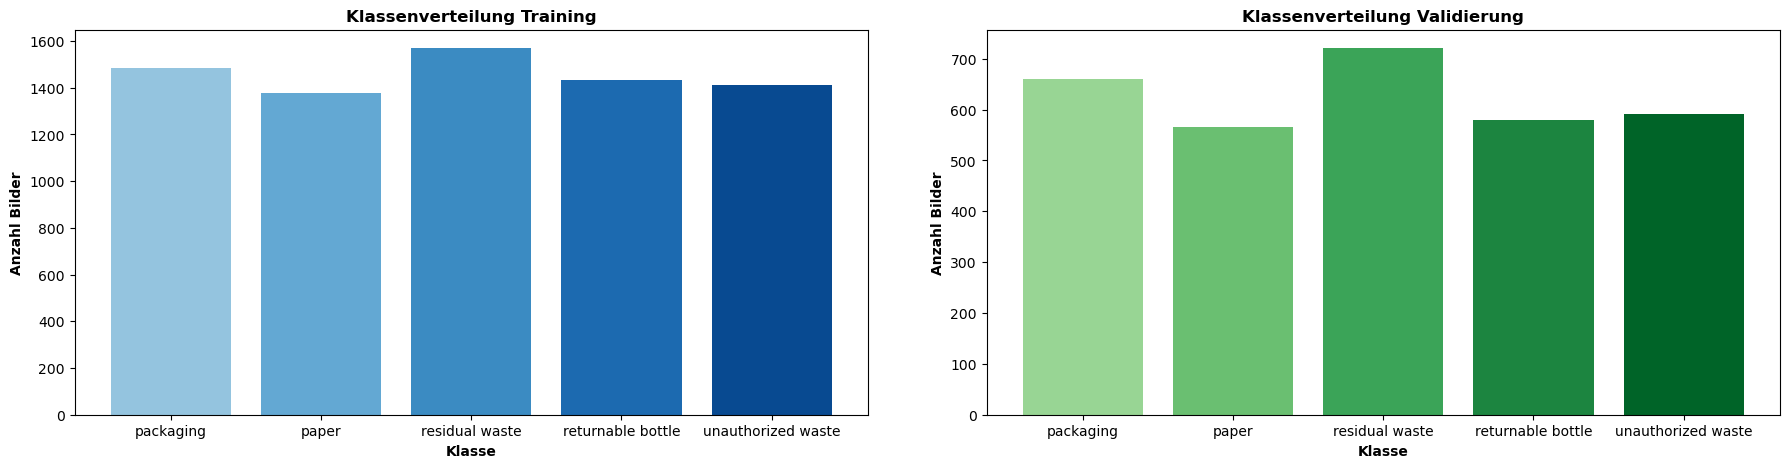

In [22]:
# --- Train ---
train_dist = count_classes_subset(extern_train_loader.dataset, extern_full_dataset.classes)

# --- Validation ---
val_dist = count_classes_subset(extern_val_loader.dataset, extern_full_dataset.classes)

# --- Plot ---
print_train_val_distribution(train_dist, val_dist, extern_full_dataset.classes)

#### Zählen und Visualisieren der Custom-Subsets.

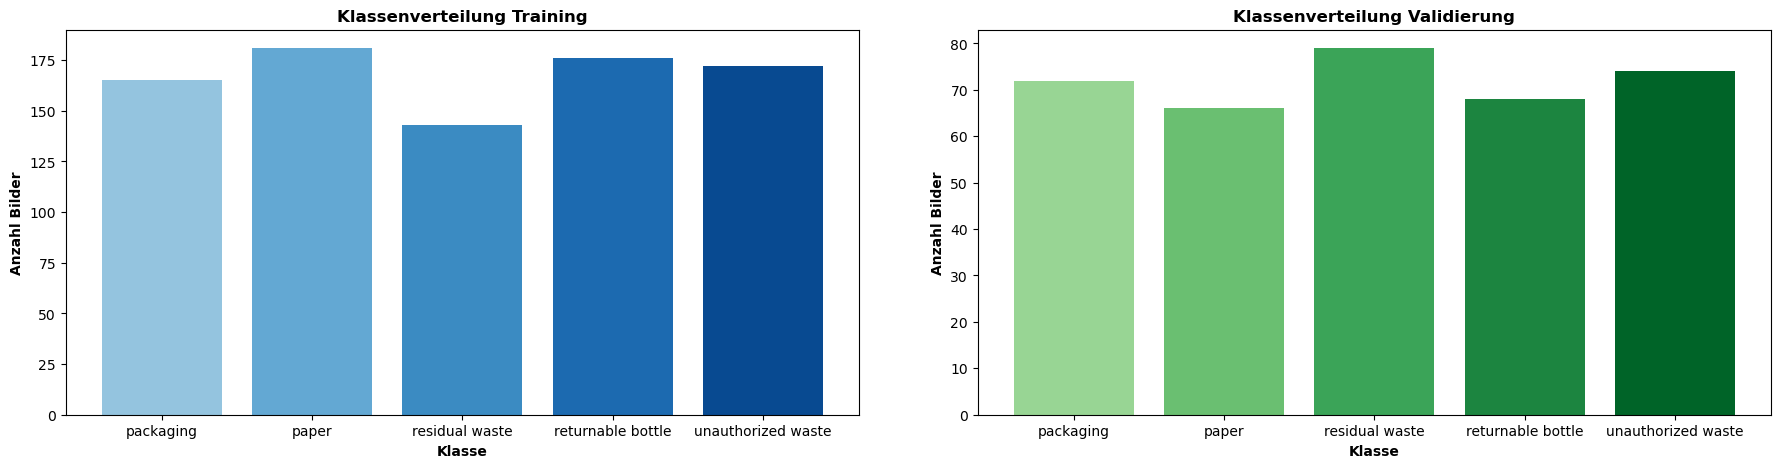

In [23]:
# --- Train ---
custom_train_dist = count_classes_subset(custom_train_loader.dataset, custom_full_dataset.classes)

# --- Validation ---
custom_val_dist = count_classes_subset(custom_val_loader.dataset, custom_full_dataset.classes)

# --- Plot ---
print_train_val_distribution(custom_train_dist, custom_val_dist, custom_full_dataset.classes)

#### Zählen und Visualisieren der All-Subsets.

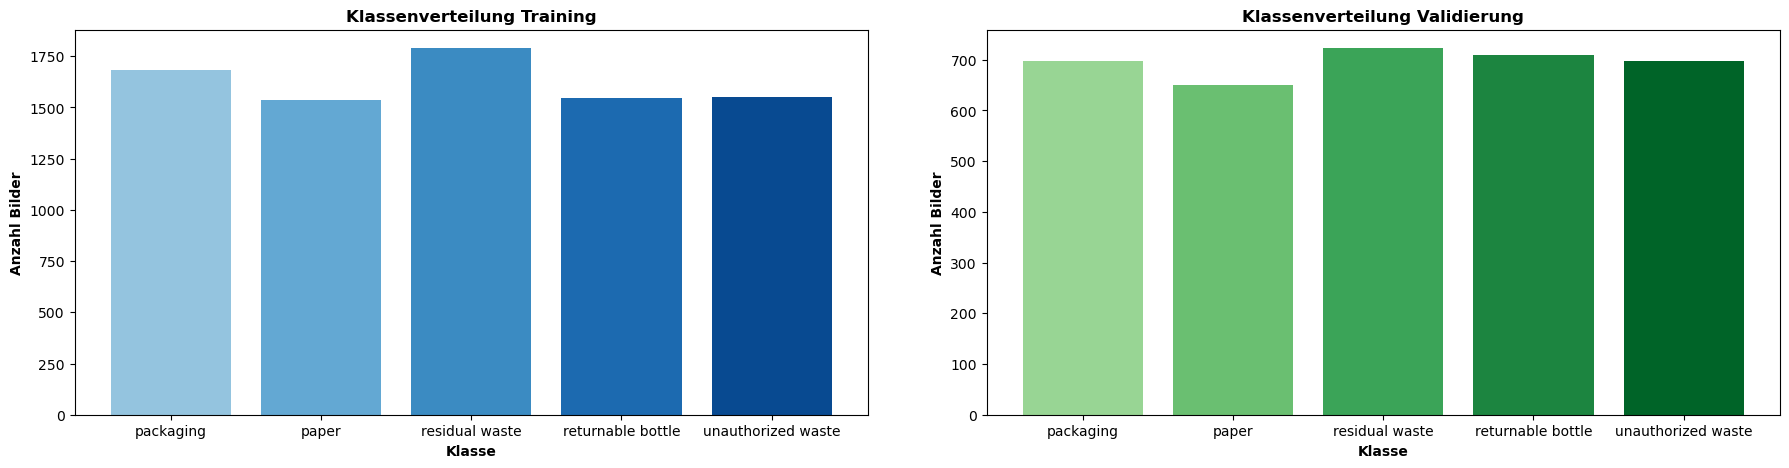

In [24]:
# --- Train ---
all_train_dist = count_classes_subset(all_train_loader.dataset, all_full_dataset.classes)

# --- Validation ---
all_val_dist = count_classes_subset(all_val_loader.dataset, all_full_dataset.classes)

# --- Plot ---
print_train_val_distribution(all_train_dist, all_val_dist, all_full_dataset.classes)

#### Datenexploration zufälliger Bilder

In diesem Schritt werden zufällig ausgewählte Bilder aus dem Datensatz gemeinsam mit ihren zugehörigen Klassennamen visualisiert. Diese visuelle Inspektion dient der qualitativen Überprüfung der Datenstruktur und ermöglicht es, mögliche Fehlzuordnungen oder Auffälligkeiten im Datensatz frühzeitig zu erkennen.

In [25]:
def show_random_samples(dataset): 
    figure = plt.figure(figsize=(12, 10))
    cols, rows = 6, 1
    class_names = extern_full_dataset.classes  

    for i in range(1, rows * cols + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]

        img = img.permute(1, 2, 0)
        class_name = class_names[int(label)]

        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.title(class_name)
        plt.imshow(img)

    plt.tight_layout()
    plt.show()

#### Anzeige zufälliger Bilder des Extern-Datasets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.733682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3687146..1.6057423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8556864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


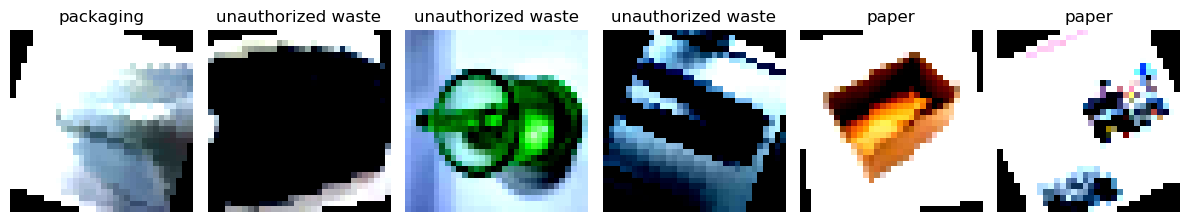

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5805322..1.4025275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..0.96455175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6680672..1.9406626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3301654..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7556022..2.169412].


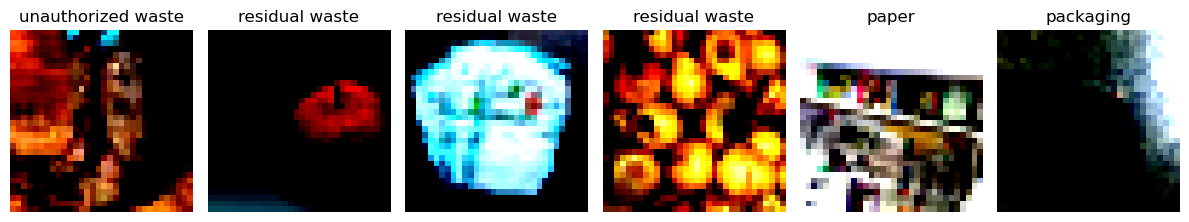

In [26]:
# --- Train ---
show_random_samples(extern_train_loader.dataset)

# --- Validation ---
show_random_samples(extern_val_loader.dataset)


#### Anzeige zufälliger Bilder des Custom-Datasets.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8207895].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9920369].


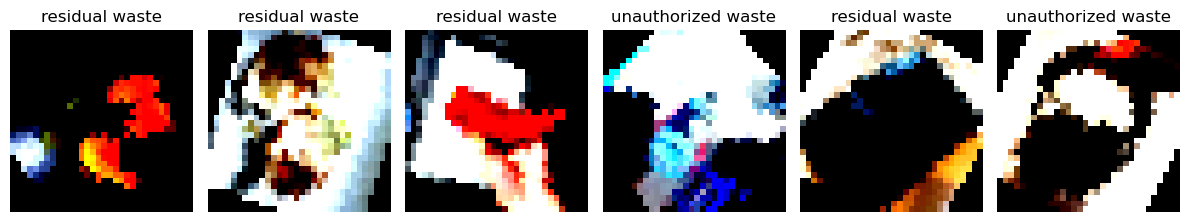

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7695861..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.1461596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7205882..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3354341..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..1.9749122].


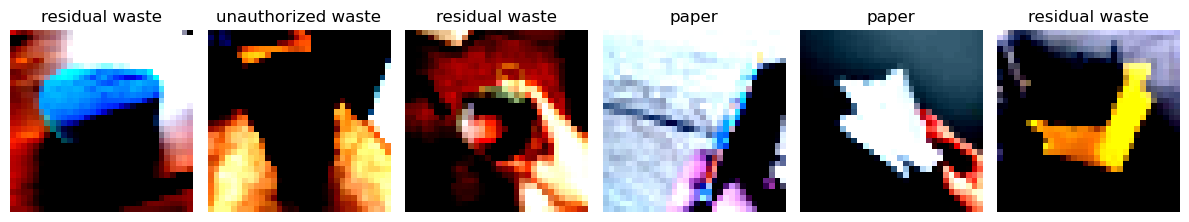

In [27]:
# --- Train ---
show_random_samples(custom_train_loader.dataset)

# --- Validation ---
show_random_samples(custom_val_loader.dataset)

#### Anzeige zufälliger Bilder des All-Datasets.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


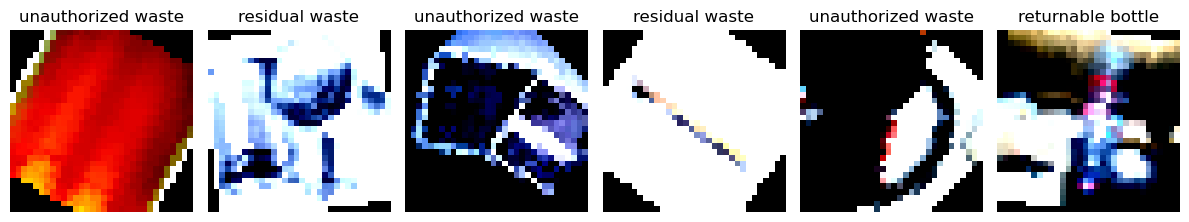

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.221423..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8256302..1.9208683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5778649..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25130582..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12543888..2.186841].


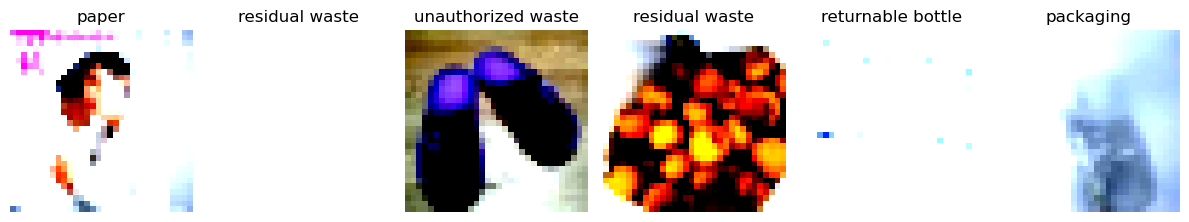

In [28]:
# --- Train ---
show_random_samples(all_train_loader.dataset)

# --- Validation ---
show_random_samples(all_val_loader.dataset)

## 4. Modellarchitekturen <a id="modellarchitekturen"></a>

1. MLP 
2. CNN 
2. Transfer Learning: VGG16 & ResNet50 <br>
    2.1. From scratch <br>
    2.2. Pretrained<br>
    2.3. Fine Tune <br>

Für die systematische Untersuchung der Datensätze wurden mehrere neuronale Modellarchitekturen ausgewählt und miteinander verglichen. Ziel ist es, identische Trainingsdaten auf unterschiedliche Netzwerkstrukturen anzuwenden, um die Auswirkungen der Architekturwahl auf die Klassifikationsleistung zu analysieren.

Als Ausgangspunkt dient ein Multi Layer Perceptron (MLP), das ausschließlich aus Fully Connected Layern besteht. Dieses Modell fungiert als einfache Baseline und ermöglicht eine erste Bewertung der grundsätzlichen Lernfähigkeit der Datensätze ohne spezialisierte Mechanismen zur Bildverarbeitung.

Darauf aufbauend wird ein Convolutional Neural Network (CNN) eingesetzt, welches durch einen Feature Extractor Merkmale lernen kann. Diese Architektur ist speziell für Bildklassifikationsaufgaben geeignet und erlaubt einen leistungsfähigeren Vergleich zur Baseline.

Ergänzend wird Transfer Learning mit den etablierten Architekturen VGG16 und ResNet50 untersucht. Dabei werden drei Trainingsstrategien betrachtet. Beim From Scratch Ansatz werden die Modelle ohne die vortrainierten Gewichte trainiert, die Gewichte werden im Training angepasst. Beim Pretrained Ansatz werden vortrainierte Gewichte genutzt, während die Feature Extraktion unverändert bleibt. Beim Fine Tuning Ansatz werden die vortrainierten Gewichte weiter angepasst, um sie auf den vorliegenden Datensatz zu spezialisieren.

Die beschriebenen Modelle werden in diesem Kapitel als eigenständige Klassen implementiert und detailliert erläutert.

#### 4.1. Multi Layer Perceptron - MLP

Die Klasse `MLP` implementiert ein **Multilayer Perceptron (MLP)** zur Klassifikation von Bilddaten.
Das Modell besteht aus einer vollständig verbundenen Hidden-Schicht mit Dropout-Regularisierung
sowie einer Ausgabeschicht zur Vorhersage der Klassenwahrscheinlichkeiten.

Die Implementierung basiert auf **PyTorch** und erbt von `torch.nn.Module`.

---

##### Zweck

Das MLP dient als **einfaches neuronales Basismodell**, um Bilddaten nach vorheriger
Serialisierung (Flattening) zu klassifizieren.  
Es eignet sich insbesondere:
- als Vergleichsmodell zu komplexeren Architekturen (z. B. CNNs),
- für Experimente mit Fully-Connected-Netzen,
- für kleinere Datensätze oder als Lernbeispiel.

---

In [29]:
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.d1 = nn.Linear(channel * image_size * image_size, config.hidden_dim)
        self.dropout = nn.Dropout(p=config.dropout)
        self.d2 = nn.Linear(config.hidden_dim, extern_class_count)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1) #serialize 3dim input

        x = self.d1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        raw_scores = self.d2(x)
        # output_predictions = torch.softmax(raw_scores , dim=1)   

        return raw_scores 

#### 4.2. Convolutional Neural Network - CNN

Die Klasse `CNN` implementiert ein **Convolutional Neural Network (CNN)** zur Bildklassifikation.
Das Modell nutzt mehrere Faltungs- und Pooling-Schichten zur Extraktion räumlicher Merkmale
sowie vollständig verbundene Schichten zur Klassifikation.

Die Implementierung basiert auf **PyTorch** und erbt von `torch.nn.Module`.

---

#### Zweck

Das CNN ist für die **automatische Merkmalsextraktion aus Bilddaten** konzipiert.
Im Gegensatz zu einem MLP nutzt es die räumliche Struktur der Bilder und eignet sich daher
besonders gut für visuelle Klassifikationsaufgaben.

Typische Einsatzbereiche:
- Bildklassifikation
- Vergleich mit einfacheren Baseline-Modellen (z. B. MLP)
- Experimente mit Regularisierung (Dropout, Batch Normalization)

---

In [30]:
class CNN(nn.Module):
    def __init__(self, config):
        super(CNN, self).__init__()
        self.drop=nn.Dropout2d(config.dropout)
        self.dropfc=nn.Dropout(config.dropout)
        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512*2*2, config.hidden_dim_1)
        self.fc2 = nn.Linear(config.hidden_dim_1, extern_class_count)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.drop(self.conv1(x)))))
        x = self.pool(F.relu(self.bn2(self.drop(self.conv2(x)))))
        x = self.pool(F.relu(self.bn3(self.drop(self.conv3(x)))))
        x = self.pool(F.relu(self.bn4(self.drop(self.conv4(x)))))
        x = x.view(-1, 512*2*2)
        x = F.relu(self.dropfc(self.fc1(x)))
        x = self.fc2(x)
        return x

#### 4.3. Transfer Learning 

##### 4.3.1. VGG16 Modell


Die Klasse `VGG16` implementiert ein **auf VGG16 basierendes Convolutional Neural Network**
für die Bildklassifikation. Je nach Konfiguration kann das Modell
- **von Grund auf neu trainiert**,
- **als eingefrorenes, vortrainiertes Modell genutzt**
- oder **feinjustiert (Fine-Tuning)** werden.

Die Implementierung nutzt das vortrainierte **VGG16-Modell aus `torchvision.models`**
und passt die Architektur an die Zielklassen des Datensatzes an.

---

#### Zweck

Dieses Modell dient zur **leistungsstarken Bildklassifikation** unter Nutzung von
**Transfer Learning**. Durch die Wiederverwendung vortrainierter Gewichte
(konzipiert für ImageNet) kann auch bei kleineren Datensätzen eine hohe
Generalisierungsleistung erreicht werden.

Typische Einsatzszenarien:
- Transfer Learning
- Fine-Tuning vortrainierter CNNs
- Vergleich mit selbst implementierten CNN-Architekturen

---

In [31]:
class VGG16(nn.Module):
    def __init__(self, config):
        super(VGG16, self).__init__()
        self.config = config
        
        if config.model_subtype == "TRAIN_FROM_SCRATCH":
            self.model = models.vgg16(pretrained=False)
            for param in self.model.parameters():
                param.requires_grad = True
        elif config.model_subtype == "TRAIN_PRETRAINED":
            self.model = models.vgg16(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = False
        elif config.model_subtype == "TRAIN_FINETUNE":
            self.model = models.vgg16(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            raise ValueError(f"Unknown model_subtype {config.model_subtype}")
        
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, config.hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, extern_class_count)
        )

    def forward(self, x):
        return self.model(x)


##### 4.3.2. ResNet50

Die Klasse `ResNet50` implementiert ein **auf ResNet50 basierendes Deep Convolutional Neural Network**
zur Bildklassifikation. Ähnlich zur `VGG16`-Klasse nutzt dieses Modell **Transfer Learning**
und erlaubt verschiedene Trainingsstrategien, unterscheidet sich jedoch grundlegend in seiner
Architektur durch die Verwendung von **Residual Connections**.

Die Implementierung basiert auf dem vortrainierten **ResNet50-Modell aus `torchvision.models`**.

---

#### Zweck

Das ResNet50-Modell wird eingesetzt, um:
- die Leistungsfähigkeit moderner, tiefer CNN-Architekturen zu evaluieren,
- **VGG16 und ResNet50 direkt miteinander zu vergleichen**,
- die Auswirkungen von Architekturentscheidungen (Tiefe, Residual Connections)
  auf Trainingsstabilität und Generalisierung zu analysieren.

Insbesondere steht hier der **Vergleich zwischen klassischen CNNs (VGG16) und Residual Networks**
im Fokus der Untersuchung.

---

In [32]:
class ResNet50(nn.Module):
    def __init__(self, config):
        super(ResNet50, self).__init__()
        self.config = config
        
        if config.model_subtype == "TRAIN_FROM_SCRATCH":
            self.model = models.resnet50(pretrained=False) 
            for param in self.model.parameters():
                param.requires_grad = True

        elif config.model_subtype == "TRAIN_PRETRAINED":
            self.model = models.resnet50(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = False

        elif config.model_subtype == "TRAIN_FINETUNE":
            self.model = models.resnet50(pretrained=True)
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            raise ValueError(f"Unknown model_subtype {config.model_subtype}")

        num_ftrs = self.model.fc.in_features 

        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs, config.hidden_dim), 
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, extern_class_count)
        )

    def forward(self, x):
        return self.model(x)

## 5. Trainieren & Testen <a id="training"></a>

### 5.1. Funktionen

#### Funktion `get_model`

Die Funktion `get_model` ist eine **zentrale Factory-Funktion** zur Initialisierung
von Modellen, Optimierern und Verlustfunktionen.
Sie kapselt die gesamte Modellkonfiguration und stellt sicher, dass
alle Experimente konsistent und vergleichbar durchgeführt werden.

---

#### Zweck

Diese Funktion dient dazu:
- unterschiedliche Modellarchitekturen **einheitlich zu initialisieren**,
- passende Optimierer abhängig vom Modelltyp zu wählen,
- eine gemeinsame Verlustfunktion zu definieren,
- die Modelle automatisch auf das Zielgerät (CPU/GPU) zu verschieben,
- eine übersichtliche Modellzusammenfassung auszugeben.

Dadurch wird ein **fairer Vergleich zwischen MLP, CNN, VGG16 und ResNet50**
ermöglicht, ohne Code-Duplikation oder inkonsistente Trainingspipelines.

---

In [33]:
def get_model(config):
    print(config)
    if config.model_type == "MLP":
        model = MLP(config) 
        optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

    elif config.model_type == "CNN":
        model = CNN(config) 
        optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

    elif config.model_type == "TRANSFER_VGG":
        model = VGG16(config);  
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

    elif config.model_type == "TRANSFER_RN":
        model = ResNet50(config);  
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        loss_fn = nn.CrossEntropyLoss()
    else:
        raise ValueError(f"Unknown model_type {config.model_type}")
    
    model = model.to(device)
    summary(model, input_size=(channel, image_size, image_size))

    return model, optimizer, loss_fn

#### Trainings Funktionen

##### Funktion `get_accuracy`

Die Funktion `get_accuracy` berechnet die Genauigkeit eines Modells auf einer Batch von Daten. Sie vergleicht die vorhergesagten Klassen mit den Ground-Truth Labels und liefert den prozentualen Anteil korrekt klassifizierter Beispiele. Diese Maßzahl wird sowohl während des Trainings als auch der Validierung genutzt, um die Modellleistung konsistent zu überwachen.

In [34]:
def get_accuracy(output, target, batch_size):
    prediction=torch.max(output, 1)[1].view(target.size())
    corrects = (prediction.data == target.data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

##### Funktion `train_step`

Die Funktion `train_step` führt einen kompletten Trainingsdurchlauf über alle Trainingsbatches durch. Sie kapselt Vorwärtsdurchlauf, Verlustberechnung, Backpropagation und Optimierung der Modellgewichte. Gleichzeitig wird die Genauigkeit jeder Batch ermittelt und am Ende der Durchschnitt über alle Batches berechnet. Damit ermöglicht die Funktion einen modularen, reproduzierbaren Trainingsablauf, der einfach in einen Trainingsloop integriert werden kann.

In [35]:
def train_step(model, config, optimizer, loss_fn, train_loader): 
    loss_value = 0.0
    accuracy_value = 0.0


    for i, (images, labels) in enumerate(train_loader):
        model.train()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_value += loss.detach().item()
        accuracy_value += get_accuracy(outputs, labels, config.batch_size)

    loss_avg = loss_value / i
    accuracy_avg = accuracy_value / i

    return loss_avg, accuracy_avg

        

##### Funktion `val_step`

Die Funktion `val_step` führt einen Validierungsdurchlauf durch, bei dem die Modellgewichte unverändert bleiben. Gradientenberechnung wird deaktiviert und das Modell in den Evaluierungsmodus versetzt, um Dropout und BatchNorm korrekt zu handhaben. Die Funktion berechnet für jede Batch Verlust und Accuracy und gibt die durchschnittliche Performance zurück. So lässt sich die Generalisierungsfähigkeit des Modells kontinuierlich überwachen, ohne den Trainingsprozess zu beeinflussen.

In [36]:
def val_step(model, config, loss_fn, val_loader):
    loss_value = 0.0
    accuracy_value = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            model.eval()

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            loss_value += loss.detach().item()
            accuracy_value += get_accuracy(outputs, labels, config.batch_size)

    loss_avg = loss_value / i
    accuracy_avg = accuracy_value / i

    return loss_avg, accuracy_avg

#### Funktion `print_results`

Die Funktion `print_results` visualisiert und bewertet die Leistung eines trainierten Modells. Sie erzeugt eine grafische Übersicht des Trainingsverlaufs durch die Darstellung von Trainings- und Validierungsgenauigkeit über alle Epochen und ermöglicht eine detaillierte Analyse der Modellvorhersagen auf dem Validierungsdatensatz.

#### Zweck

Diese Funktion dient dazu:
- den Trainings- und Validierungsverlauf anschaulich darzustellen,
- die Modellleistung auf dem Validierungsdatensatz quantitativ zu bewerten,
- eine Klassifikationsmatrix (classification_report) mit Precision, Recall und F1-Score auszugeben,
- die Confusion Matrix grafisch darzustellen, um zu erkennen, welche Klassen vom Modell häufig verwechselt werden.

Durch die Kombination aus Plotten der Accuracy, numerischer Bewertung und Confusion Matrix liefert die Funktion eine umfassende Übersicht über die Stärken und Schwächen des Modells und unterstützt die Analyse der Generalisierungsfähigkeit auf neuen Daten.

In [37]:
def print_results(num_epochs, train_accuracy, val_accuracy, model, val_loader, full_dataset):

    # print training and validation accuracy plot
    plt.figure(figsize=(12,8))
    plt.plot(range(num_epochs),train_accuracy,"r",label="training accuracy")
    plt.plot(range(num_epochs),val_accuracy,"b",label="validation accuracy")
    plt.xlabel("epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # evaluate on validation set
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # print classification report 
    print(classification_report(y_true, y_pred))

    # print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.xlabel('Vorhergesagte Klasse (Prediction)')
    plt.ylabel('Wahre Klasse (True Label)')
    plt.title('Confusion Matrix: Was wird womit verwechselt?')
    plt.show()

#### Funktion `run_training_loop`

Die Funktion `run_training_loop` steuert den kompletten Trainingsprozess eines Modells über eine vorgegebene Anzahl von Epochen. Sie kombiniert Training, Validierung, Logging und abschließende Ergebnisvisualisierung mithilfe der oben definierten Funktionen und sorgt dafür, dass der Fortschritt sowohl numerisch als auch grafisch nachvollziehbar ist.

#### Zweck

Diese Funktion dient dazu:
- den Trainings- und Validierungsprozess automatisch zu durchlaufen,
- die durchschnittlichen Verluste und Genauigkeiten pro Epoche zu berechnen und zu speichern,
- Ergebnisse in der Konsole übersichtlich auszugeben,
- Trainingsmetriken kontinuierlich an WandB (Weights & Biases) zu übermitteln, um Experimente zu protokollieren,
- abschließend die Leistung des Modells visuell und analytisch auszuwerten, inklusive Accuracy-Verlauf, Klassifikationsreport und Confusion Matrix.

Durch die Verwendung von run_training_loop lässt sich der gesamte Trainingsworkflow einheitlich, reproduzierbar und nachvollziehbar durchführen, was die Analyse von Modellverhalten und Generalisierungsfähigkeit deutlich erleichtert.

In [38]:
def run_training_loop(name, model, config, optimizer, loss_fn, train_loader, val_loader, full_dataset ):
    print(f"Start training for {name} with {config.epochs} epochs...") 
    
    model = model.to(device) 

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(config.epochs):
        
        train_loss_avg, train_accuracy_avg = train_step(model, config, optimizer, loss_fn, train_loader)
        val_loss_avg, val_accuracy_avg = val_step(model, config, loss_fn, val_loader)

        history['train_loss'].append(train_loss_avg)
        history['train_accuracy'].append(train_accuracy_avg)
        history['val_loss'].append(val_loss_avg)
        history['val_accuracy'].append(val_accuracy_avg)

        print(f"Epoch [{epoch+1}/{config.epochs}], "
              f"Train Loss: {train_loss_avg:.4f}, Train Acc: {train_accuracy_avg:.2f}%, "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy_avg:.2f}%")
        
    
        wandb.log({
            "train_loss": train_loss_avg,
            "train_accuracy": train_accuracy_avg,
            "val_loss": val_loss_avg,
            "val_accuracy": val_accuracy_avg
        })
    
    print_results(config.epochs, history['train_accuracy'], history['val_accuracy'], model, val_loader , full_dataset)

#### Modell-Trainingspipelines

Diese Funktionen starten eine vollständige Trainings-Pipeline für ein Modell. Sie initialisieren einen Weights-&-Biases-Run, bekommen Modell, Optimizer und Loss-Funktion basierend auf der oben implementierten Factory-Funktion und führen das Training inklusive Validierung über `run_training_loop` durch.  

Der Unterschied zwischen den drei unten initialisierten Pipeline-Funktionen liegt in den verwendeten Daten:  
- `custom_model_pipeline` nutzt den **Custom-Datensatz**,  
- `extern_model_pipeline` den **externen Datensatz**,  
- `all_model_pipeline` den **kombinierten Datensatz** aus beiden Quellen.

In [39]:
def extern_model_pipeline(name, config=None):
    
    with wandb.init(project=WANDB_PROJECT, config=config):
        config = wandb.config
        print(f"Running model pipeline: {name}, with config: {config}")

        model, optimizer, loss_fn = get_model(config)

        run_training_loop(name, model, config, optimizer, loss_fn, extern_train_loader, extern_val_loader, extern_full_dataset)

In [40]:
def custom_model_pipeline(name, config):
    
    with wandb.init(project=WANDB_PROJECT, config=config):
        config = wandb.config

        model, optimizer, loss_fn = get_model(config)

        run_training_loop(name, model, config, optimizer, loss_fn, custom_train_loader, custom_val_loader, custom_full_dataset)

In [41]:
def all_model_pipeline(name, config):
    with wandb.init(project=WANDB_PROJECT, config=config):
        config = wandb.config

        model, optimizer, loss_fn = get_model(config)

        run_training_loop(name, model, config, optimizer, loss_fn, all_train_loader, all_val_loader, all_full_dataset)

### 5.2. Pipelines

Zur Anwendung der zuvor definierten Funktionen auf die jeweiligen Modellarchitekturen werden die  Pipelines ausgeführt. Diese Pipelines übernehmen die vollständige Verarbeitungskette von der Datenvorverarbeitung über das Modelltraining bis zur Evaluation auf den Testdaten.

Im Rahmen der Experimente wurden verschiedene Kombinationen aus Modellarchitekturen und Datensätzen untersucht, um die Leistungsfähigkeit der einzelnen Ansätze systematisch zu vergleichen.

Wir haben folgende Kombinationen ausgeführt: 
<table style="border-collapse: collapse; margin-right:20px;">
  <tr>
    <th>Modellarchitektur</th>
    <th>Daten</th>
  </tr>

  <tr>
    <td><b>MLP</b></td>
    <td>
      <ul>
        <li>externe Daten</li>
      </ul>
    </td>
  </tr>

   <tr>
    <td><b>CNN</b></td>
    <td>
      <ul>
        <li>externe Daten</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td><b>VGG16</b></td>
    <td>
      <ul>
        <li>externe Daten: From Scratch, Pretrained und Finetune</li>
        <li>eigenen Daten: Finetune</li>
        <li>allen Daten: Finetune</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td><b>ResNet50</b></td>
    <td>
      <ul>
        <li>externe Daten: Finetune</li>
        <li>eigenen Daten: Finetune</li>
        <li>allen Daten: Finetune</li>
      </ul>
    </td>
  </tr>

  <tr>
    <td><b>Hyperparametisierung</b></td>
    <td>
      <ul>
        <li>externe Daten</li>
      </ul>
    </td>
  </tr>
</table>

Für jedes Modell wird nach Ausführung der Pipeline ein Diagramm erstellt, das die Trainings- und Validierungsergebnisse darstellt. Auf der Y-Achse ist die Accuracy abgetragen, die X-Achse zeigt die einzelnen Epochen.

Der Classification Report zeigt für jede Klasse die wichtigen Metriken **Precision**, **Recall** und **F1-Score** sowie die Anzahl der Validierungsdaten (**Support**). Zusätzlich wird die **Accuracy** über alle Klassen hinweg angezeigt, und es werden sowohl der **Macro- als auch der Weighted-Durchschnitt** der Metriken ausgegeben, um die Modellleistung zusammenfassend zu bewerten.

Die Confusion Matrix zeigt, wie viele der Validierungsdaten korrekt klassifiziert wurden. Eine stark ausgeprägte Diagonale ist ein positiver Hinweis auf die Modellleistung. Außerdem lassen sich häufige Fehlklassifikationen erkennen, die auf den Feldern neben der Diagonale ablesbar sind.

### MLP mit externen Daten 

Running model pipeline: MLP, with config: {'model_type': 'MLP', 'batch_size': 16, 'learning_rate': 0.005, 'epochs': 30, 'hidden_dim': 256, 'dropout': 0.2}
{'model_type': 'MLP', 'batch_size': 16, 'learning_rate': 0.005, 'epochs': 30, 'hidden_dim': 256, 'dropout': 0.2}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
           Dropout-2                  [-1, 256]               0
            Linear-3                    [-1, 5]           1,285
Total params: 787,973
Trainable params: 787,973
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.01
Estimated Total Size (MB): 3.02
----------------------------------------------------------------
Start training for MLP with 30 epochs...
Epoch [1/30], Train Loss: 1.4198, Train Acc: 39.26%, 

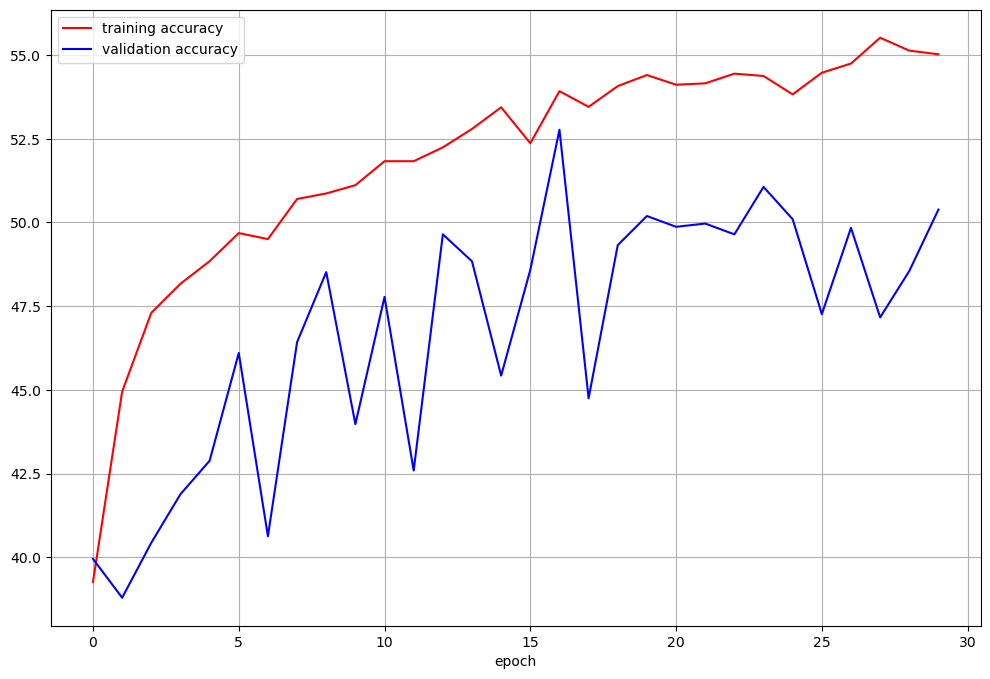

              precision    recall  f1-score   support

           0       0.62      0.39      0.48       661
           1       0.51      0.41      0.45       565
           2       0.42      0.56      0.48       721
           3       0.61      0.55      0.58       580
           4       0.47      0.59      0.52       591

    accuracy                           0.50      3118
   macro avg       0.52      0.50      0.50      3118
weighted avg       0.52      0.50      0.50      3118



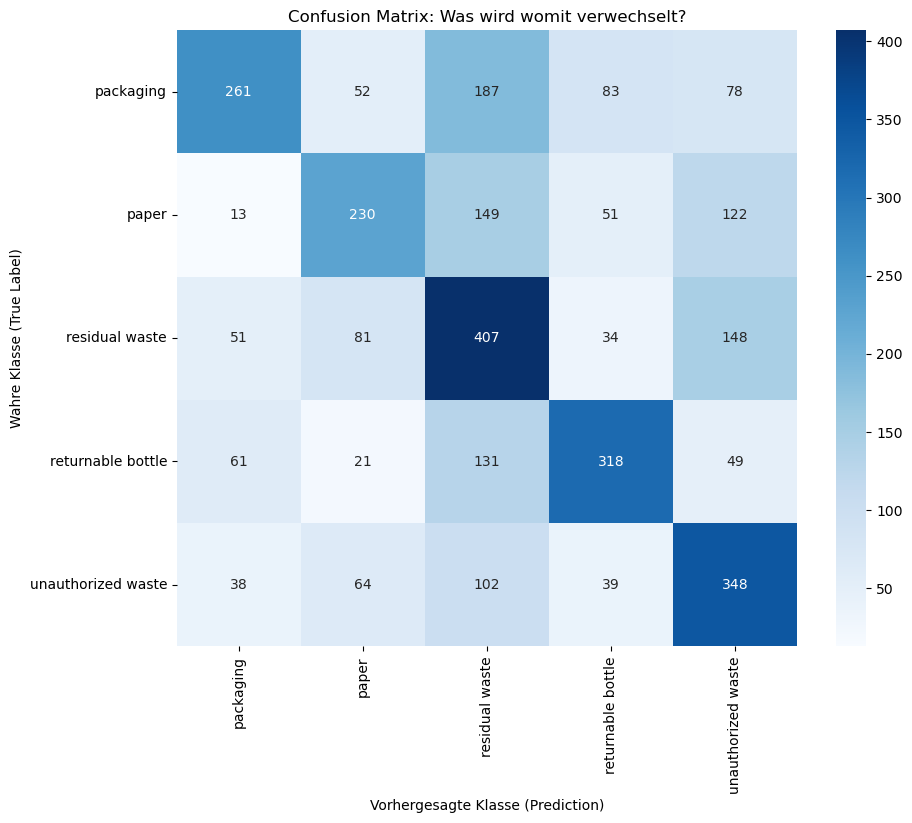

train_accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇██▇█████
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
val_accuracy,▂▁▂▃▃▅▂▅▆▄▆▃▆▆▄▆█▄▆▇▇▇▆▇▇▅▇▅▆▇
val_loss,▇██▆▅▅█▄▃▇▃█▂▃▅▃▁▆▃▂▂▂▂▂▃▄▂▄▄▁
train_accuracy,55.02478
train_loss,1.16881
val_accuracy,50.3866
val_loss,1.23804


In [45]:
extern_model_pipeline("MLP", config_mlp)

#### Beschreibung und Auswertung (MLP mit externen Daten)
Das Diagramm zeigt die Trainings- und Validierungskurven für das Modell MLP mit externen Daten. Die Trainingsaccuracy steigt nahezu kontinuierlich auf etwa 55,02 % an. Der Anstieg ist zu Beginn stark und flacht im späteren Verlauf ab, was darauf hinweist, dass das Modell die Trainingsdaten zunehmend besser erlernt. Die Validierungsaccuracy steigt insgesamt ebenfalls an, liegt jedoch dauerhaft unter der Trainingsaccuracy. Zudem zeigt sie deutliche Schwankungen mit einzelnen Spitzen und anschließenden Einbrüchen. Gegen Ende stabilisiert sie sich bei etwa 50,38 %. Dies deutet darauf hin, dass das Modell zwar lernt, die Generalisierung auf unbekannte Daten jedoch noch nicht stabil ist.

Im Classification Report zeigt sich, dass das Modell insgesamt eine mittlere Leistung erreicht. Die Klasse Pfandflaschen wird am zuverlässigsten erkannt, während andere Klassen entweder viele echte Beispiele übersehen oder häufiger falsch vorhergesagt werden. Die Gesamtgenauigkeit von etwa 50 % zeigt, dass das Modell zwar grundlegende Muster gelernt hat, die Trennschärfe zwischen den Klassen jedoch noch nicht ausreichend stabil ist.
<br><br>
Betrachtet man nun die Confusion Matrix, sind die Ergebnisse klar nachvollziehbar. Die Diagonale ist erkennbar, aber nur schwach ausgeprägt, was darauf hinweist, dass zwar viele Beispiele korrekt klassifiziert werden, jedoch weiterhin eine beträchtliche Anzahl an Fehlzuordnungen existiert. Die Klasse Restmüll weist die meisten korrekten Zuordnungen auf mit 407 richtig erkannten Beispielen. Besonders häufige Verwechslungen treten zwischen Restmüll und Fremdmüll mit 148 Fehlklassifikationen sowie zwischen Verpackungen und Restmüll mit 187 Fehlklassifikationen auf. Diese Fehlklassifikationen lassen sich dadurch erklären, dass sich diese Abfallarten visuell stark ähneln und daher nur schwer unterscheidbare Merkmale besitzen. 

Zusammenfassend zeigt sich, dass das Modell zwar lernfähig ist und grundlegende Muster erkennt, die Gesamtleistung jedoch noch begrenzt bleibt. Die starke Differenz zwischen Trainings- und Validierungsaccuracy sowie die erkennbaren Fehlklassifikationen in der Confusion Matrix deuten auf eine noch unzureichende Generalisierung hin. Insbesondere visuell ähnliche Abfallkategorien stellen eine Herausforderung dar. Für eine bessere Modellleistung wären zusätzliche Trainingsdaten oder eine Anpassung der Modellarchitektur mit einem Feature Extractor sinnvoll.

### CNN mit externen Daten 

Running model pipeline: CNN, with config: {'model_type': 'CNN', 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 30, 'hidden_dim_1': 1024, 'dropout': 0.2}
{'model_type': 'CNN', 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 30, 'hidden_dim_1': 1024, 'dropout': 0.2}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         Dropout2d-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         Dropout2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
        Dropout2d-10   

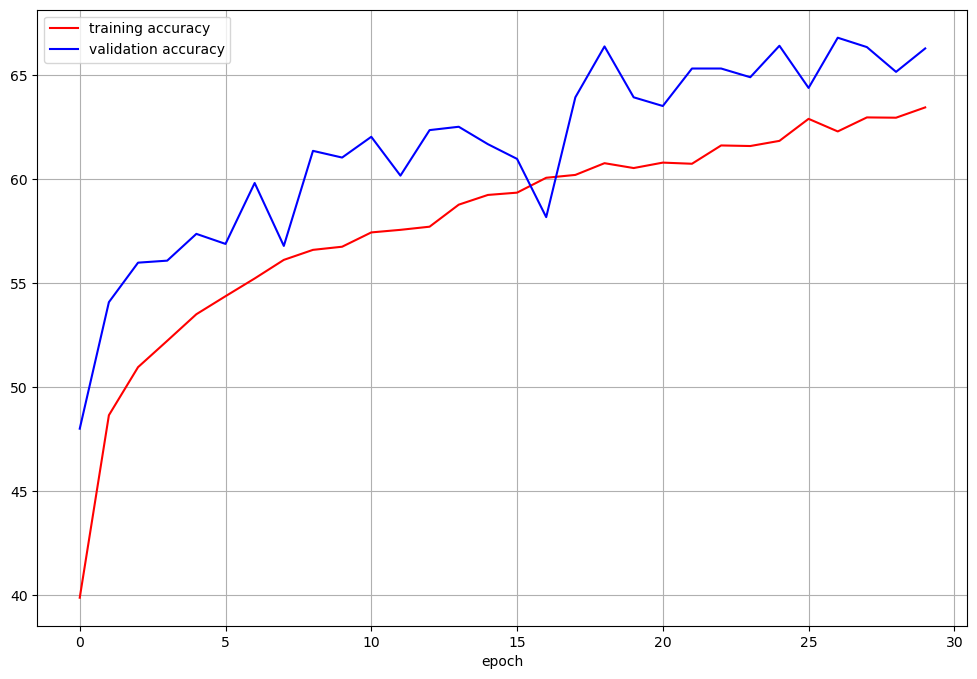

              precision    recall  f1-score   support

           0       0.63      0.68      0.66       661
           1       0.65      0.70      0.67       565
           2       0.70      0.56      0.62       721
           3       0.83      0.68      0.75       580
           4       0.56      0.69      0.62       591

    accuracy                           0.66      3118
   macro avg       0.67      0.66      0.66      3118
weighted avg       0.67      0.66      0.66      3118



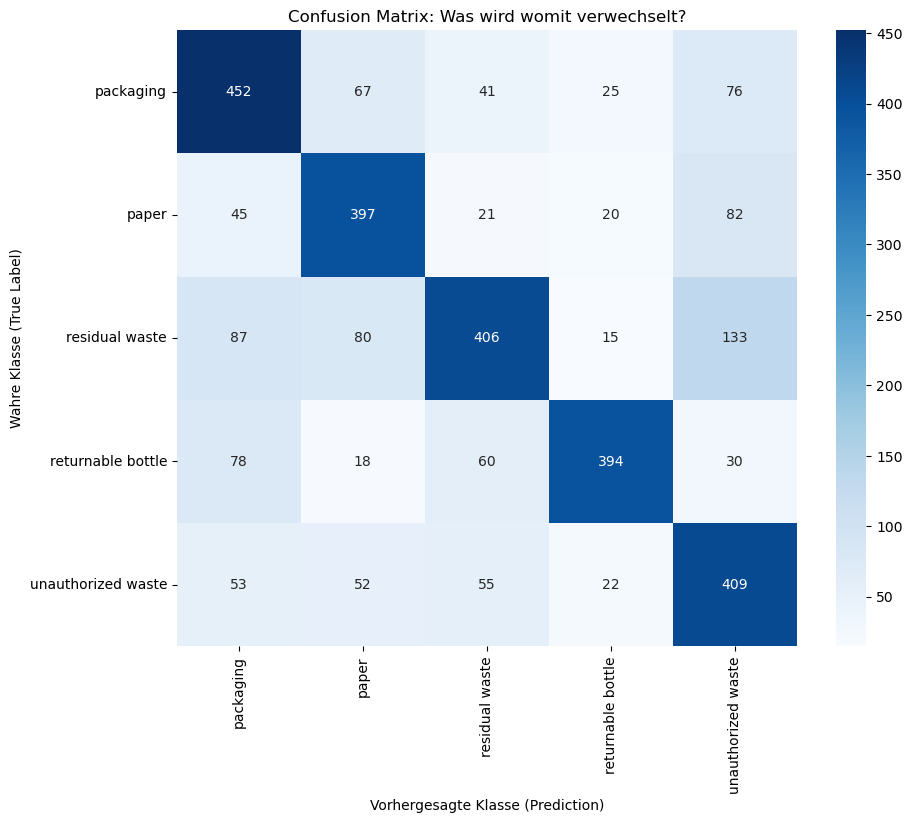

train_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▄▄▅▄▆▆▆▆▆▆▆▆▅▇█▇▇▇▇▇█▇██▇█
val_loss,█▆▅▅▅▅▄▅▃▃▂▃▂▂▂▃▅▁▁▁▂▂▁▂▂▂▁▁▁▁
train_accuracy,63.46366
train_loss,0.96737
val_accuracy,66.30155
val_loss,0.95458


In [42]:
extern_model_pipeline("CNN", config_cnn)

### Beschreibung und Auswertung (CNN mit externen Daten)

Das Diagramm zeigt beim CNN, dass die Trainings- und Validierungskurve über die Epochen kontinuierlich ansteigen, was auf einen erfolgreichen Lernprozess hinweist. Am Ende erreicht das Modell auf den Trainingsdaten eine Accuracy von etwa 63,5%, während die Validierungsdaten eine Accuracy von rund 66,3% aufweisen.

Im Classification Report zeigt sich, dass die Klasse 3 (Pfandflaschen) den höchsten F1-Score erreicht hat, was darauf hinweist, dass das Modell diese Klasse am zuverlässigsten erkannt und die Balance zwischen Precision und Recall für diese Klasse am besten umgesetzt hat. 

Die Confusion Matrix bestätigt diese Beobachtungen. Besonders häufige Fehlklassifikationen treten zwischen residual waste und unauthorized waste sowie zwischen packaging und paper auf. Diese Verwechslungen lassen sich inhaltlich dadurch erklären, dass sich diese Abfallkategorien visuell stark ähneln und somit schwer trennbare Merkmale besitzen. Dagegen wird returnable bottle nur selten mit anderen Klassen verwechselt, was die hohe Modellleistung für diese Kategorie erklärt.

Zusammenfassend lässt sich eine solide Gesamtleistung erkennen, allerdings sind die zugrunde liegenden Muster noch nicht vollständig erfasst, was sich anhand der weiterhin vorhandenen Fehlklassifikationen widerspiegelt. Die Trainings- und Validierungsdaten deuten auf ein leichtes Underfitting hin, da die Validierungsergebnisse etwas besser abschneiden als die Trainingsergebnisse.

### VGG16 - From Scratch mit externen Daten 

Running model pipeline: Transfer Learning - From Scratch, with config: {'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FROM_SCRATCH', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'hidden_dim': 128, 'dropout': 0.2}
{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FROM_SCRATCH', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

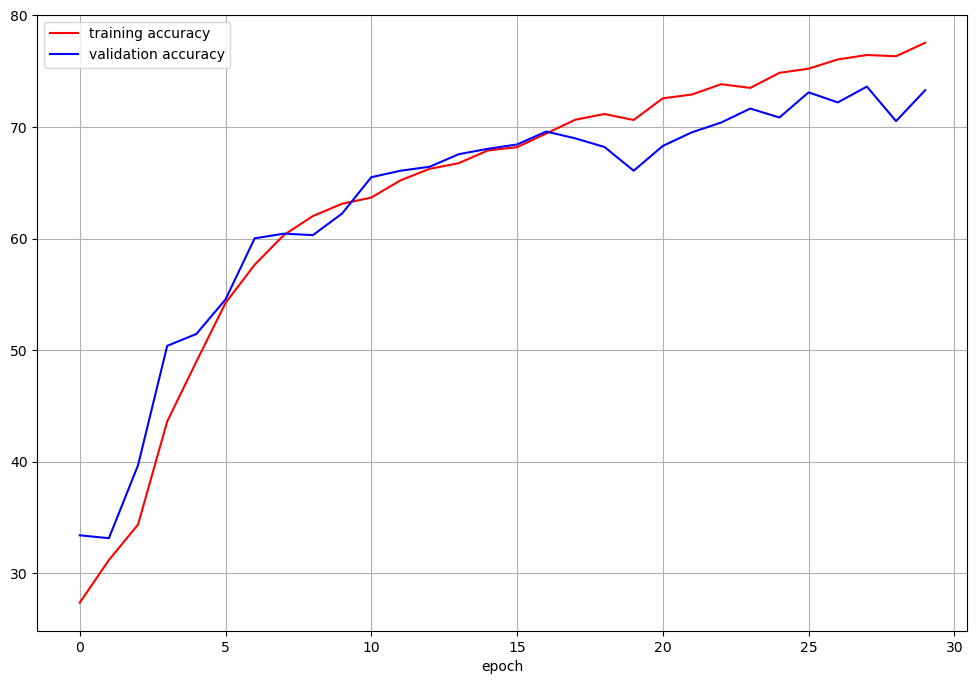

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       661
           1       0.79      0.71      0.75       565
           2       0.65      0.79      0.72       721
           3       0.77      0.88      0.82       580
           4       0.74      0.60      0.67       591

    accuracy                           0.73      3118
   macro avg       0.74      0.73      0.73      3118
weighted avg       0.73      0.73      0.73      3118



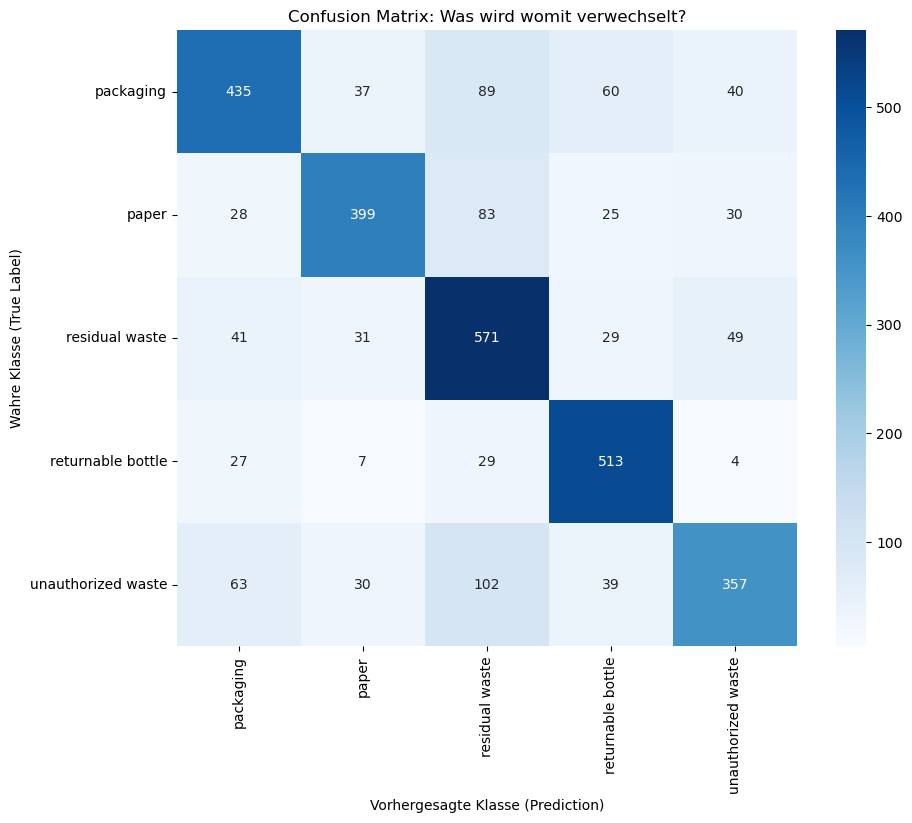

train_accuracy,▁▂▂▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train_loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇█
val_loss,██▇▆▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▃▂▂▂▁▂▁▁▁▁▁
train_accuracy,77.54681
train_loss,0.62835
val_accuracy,73.29253
val_loss,0.76753


In [43]:
extern_model_pipeline("Transfer Learning - From Scratch", config_transfer_vgg["scratch"])

### Beschreibung und Auswertung (VGG16 - From Scratch mit externen Daten)

Der Verlauf der Genauigkeitswerte über die Trainingsdauer zeigt für das VGG16 Modell im From Scratch Ansatz einen stetigen Anstieg der Trainings und Validierungswerte. Nach Abschluss des Trainings erreicht das Modell eine Trainingsaccuracy von 77,55 % sowie eine Validierungsaccuracy von 73,29 %. Der Abstand zwischen beiden Kurven bleibt über die Epochen hinweg begrenzt.

Die Analyse des Classification Reports verdeutlicht Unterschiede in der Erkennungsleistung zwischen den Klassen. Pfandflaschen werden mit einem F1 Score von 0.82 am präzisesten klassifiziert. Verpackungen weisen mit einem F1 Score von 0.69 die geringste Übereinstimmung zwischen Precision und Recall auf.

Die Confusion Matrix bestätigt die Gesamtgenauigkeit von rund 73 %. Besonders viele korrekte Vorhersagen entfallen auf die Klasse Restmüll. Auch Pfandflaschen werden nur selten falsch zugeordnet. Für Restmüll treten ebenfalls überwiegend richtige Klassifikationen auf.
Fehlzuordnungen lassen sich vor allem zwischen Verpackungen und Restmüll (89 Fehlklassifikationen), zwischen Fremdmüll und Restmüll (102 Fehlklassifikationen) und Papier wird vereinzelt mit Restmüll (83 Fehlklassifikationen) zu beobachten. Diese Muster deuten auf Überschneidungen in den visuellen Eigenschaften der betroffenen Kategorien hin.

Zusammenfassend erreicht das VGG16 Modell im From Scratch Ansatz eine konsistente Gesamtleistung. Während klar unterscheidbare Klassen zuverlässig erkannt werden, bleiben visuell ähnliche Kategorien eine Quelle für Fehlklassifikationen.

### VGG16 - Pretrained mit externen Daten 

Running model pipeline: Transfer Learning - Pretrained, with config: {'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_PRETRAINED', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'hidden_dim': 128, 'dropout': 0.2}
{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_PRETRAINED', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

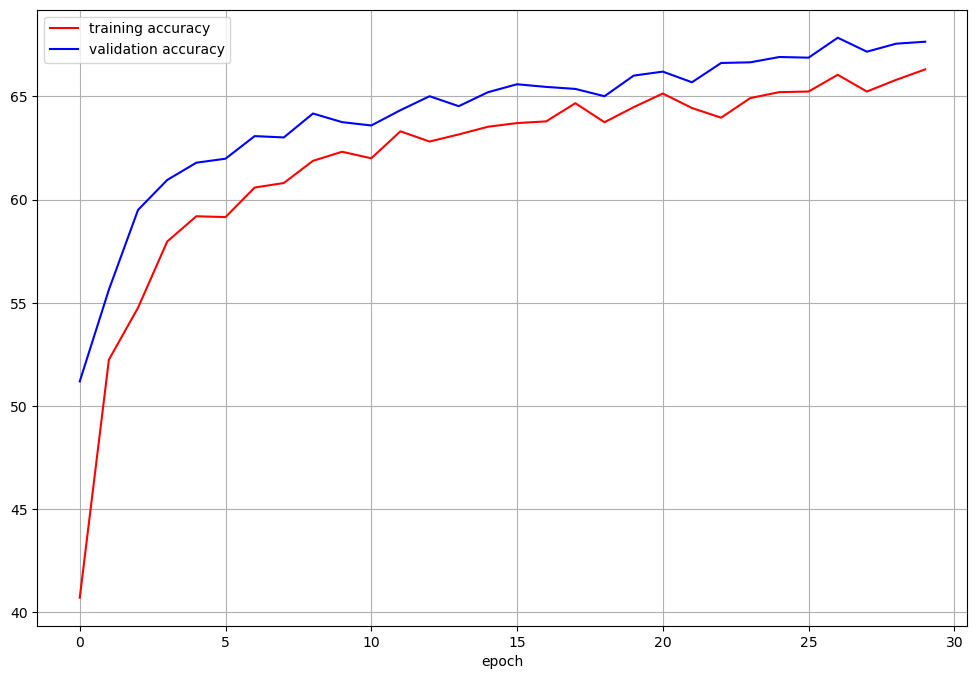

              precision    recall  f1-score   support

           0       0.65      0.52      0.58       661
           1       0.76      0.75      0.75       565
           2       0.69      0.74      0.71       721
           3       0.69      0.75      0.72       580
           4       0.58      0.62      0.60       591

    accuracy                           0.67      3118
   macro avg       0.67      0.68      0.67      3118
weighted avg       0.67      0.67      0.67      3118



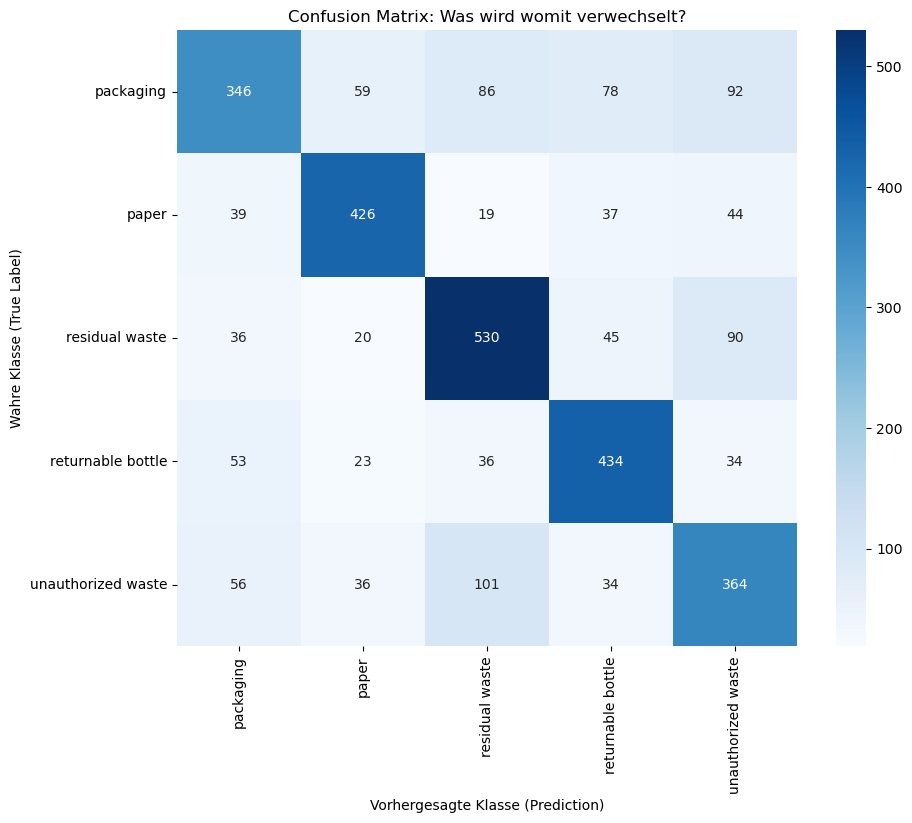

train_accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇▇███████
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
val_loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
train_accuracy,66.31333
train_loss,0.89669
val_accuracy,67.65464
val_loss,0.87322


In [44]:
extern_model_pipeline("Transfer Learning - Pretrained", config_transfer_vgg["pretrained"])

### Beschreibung und Auswertung (VGG16 - Pretrained mit externen Daten)

Betrachtet man den Lernverlauf des Pretrained VGG16, lässt sich eine stetige Verbesserung der Modellleistung beobachten. Die Trainings- und Validierungskurven steigen synchron an, ohne größere Einbrüche, und weisen zum Ende des Trainings eine Trainingsaccuracy von etwa 66,3% sowie eine leicht höhere Validierungsaccuracy von rund 67,7% auf. Dies deutet auf ein gutes Generalisierungsverhalten hin.

Ein Blick auf die detaillierten Metriken zeigt, dass das Modell insbesondere bei der Klassifizierung von Papier (Klasse 1) am stärksten ist, mit einem F1-Score von 0,75, der das beste Verhältnis von Precision und Recall widerspiegelt. Auch die Klassen „Pfandflaschen“ und „Restmüll“ werden vergleichsweise zuverlässig erkannt. Schwierigkeiten bereiten dagegen die Klassen 0 (Verpackungen) und 4 (Fremdmüll), die niedrigere F1-Werte aufweisen.

Die Analyse der Confusion Matrix verdeutlicht die spezifischen Unsicherheiten: „Fremdmüll“ wird häufig fälschlicherweise als „Restmüll“ (101 Fälle) klassifiziert. Ursache dafür ist wahrscheinlich die hohe visuelle Vielfalt und Uneinheitlichkeit dieser Abfallarten. Im Gegensatz dazu sind die Fehlerraten bei Papier und Pfandflaschen deutlich geringer.

Insgesamt liefert das VGG16 eine stabile Klassifikationsleistung, die allerdings noch verbesserungswürdig ist. Die leicht höhere Validierungsaccuracy im Vergleich zur Trainingsaccuracy spricht für gute Generalisierung, deutet aber zugleich auf mögliches Underfitting oder eine starke Regularisierung hin.

### VGG16 - Finetune mit externen Daten 

Running model pipeline: Transfer Learning - Finetune, with config: {'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}
{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

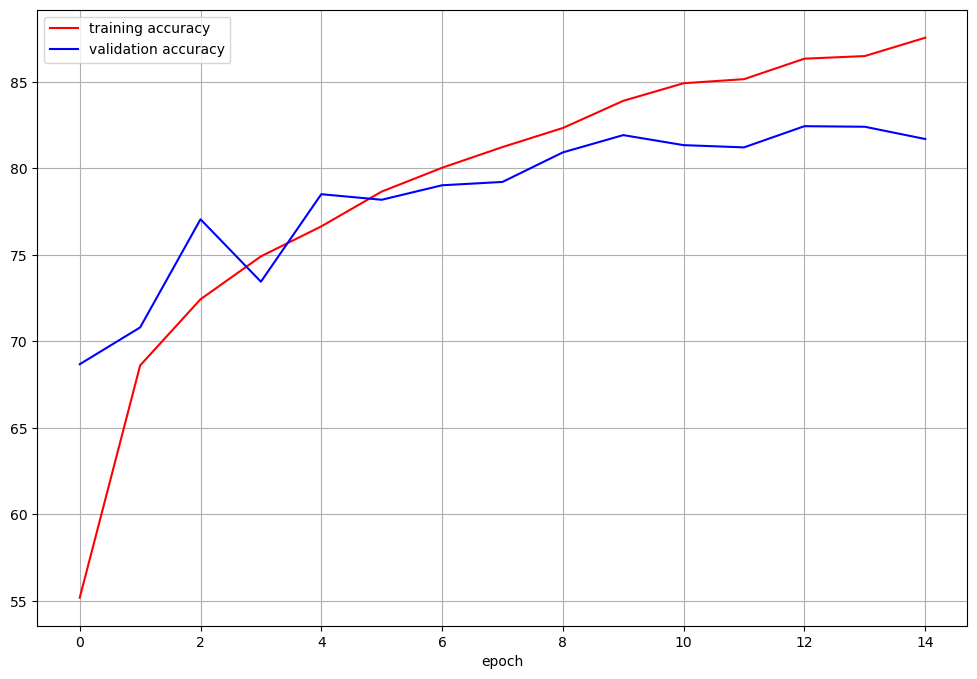

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       661
           1       0.88      0.83      0.85       565
           2       0.85      0.77      0.81       721
           3       0.80      0.94      0.86       580
           4       0.73      0.80      0.76       591

    accuracy                           0.81      3118
   macro avg       0.82      0.82      0.81      3118
weighted avg       0.82      0.81      0.81      3118



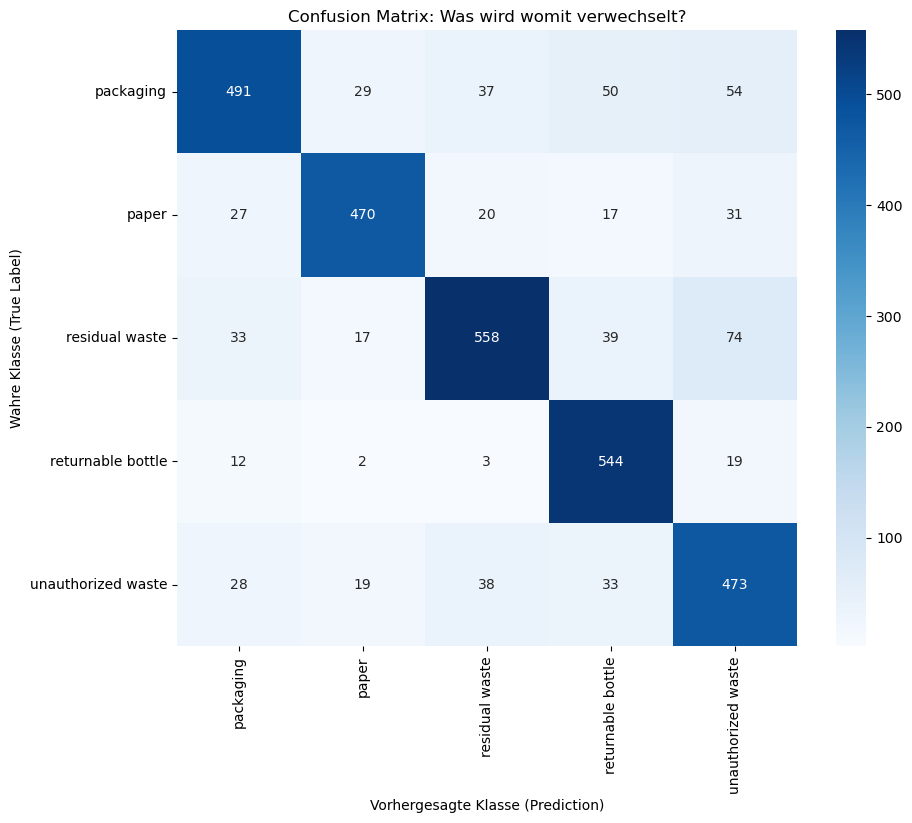

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▅▃▆▆▆▆▇█▇▇███
val_loss,█▇▄█▂▃▂▂▁▁▂▂▂▂▂
train_accuracy,87.55507
train_loss,0.34531
val_accuracy,81.70103
val_loss,0.592


In [45]:

extern_model_pipeline("Transfer Learning - Finetune", config_transfer_vgg["finetune"])

### Beschreibung und Auswertung (VGG16 - Finetune mit externen Daten)

Beim Ansatz des Transfer Learnings mit Finetuning mit externen Daten zeigt sich eine deutliche Leistungssteigerung des Modells. Die Trainingskurve steigt steil an und erreicht in der letzten Epoche eine Accuracy von rund 87,6 %. Die Validierungsgenauigkeit steigt ebenfalls stark an und erreicht in Epoche 13/14 Spitzenwerte von über 82 %, bevor sie sich zum Ende hin bei etwa 81,7 % einpendelt. Gegen Ende ist zu beobachten, dass die Trainingsaccuracy die Validierungsaccuracy leicht überholt, was auf ein beginnendes Overfitting hinweist.

Der Classification Report unterstreicht die hohe Klassifikationsleistung: Der gewichtete F1-Score liegt bei 0,81. Besonders gut erkennt das Modell Klasse 3 (Pfandflaschen) mit einem F1-Score von 0,86 und einem sehr hohen Recall von 94%. Auch Klasse 1 (Papier) wird mit einem F1-Score von 0,85 zuverlässig klassifiziert. Selbst die schwächste Klasse (Fremdmüll) erreicht einen soliden F1-Score von 0,76.

Die Confusion Matrix bestätigt die deutliche Trennung der Klassen. Die Werte auf der Diagonalen sind stark angestiegen, z. B. 544 korrekt klassifizierte Pfandflaschen. Fehlklassifikationen treten noch zwischen Restmüll und Fremdmüll auf (74 Objekte wurden fälschlicherweise zugeordnet), sind aber insgesamt deutlich reduziert.

Zusammenfassend zeigt das gefinetunte Modell eine sehr hohe Klassifikationsleistung. Es hat die visuellen Merkmale der einzelnen Abfallarten gut erlernt. Die leichte Überlegenheit der Trainingsaccuracy deutet darauf hin, dass das Modell komplex genug ist, um Trainingsdetails teilweise auswendig zu lernen, weshalb bei weiterem Training Maßnahmen gegen Overfitting sinnvoll wären.

### VGG16 - Fintune mit eigenen Daten 

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

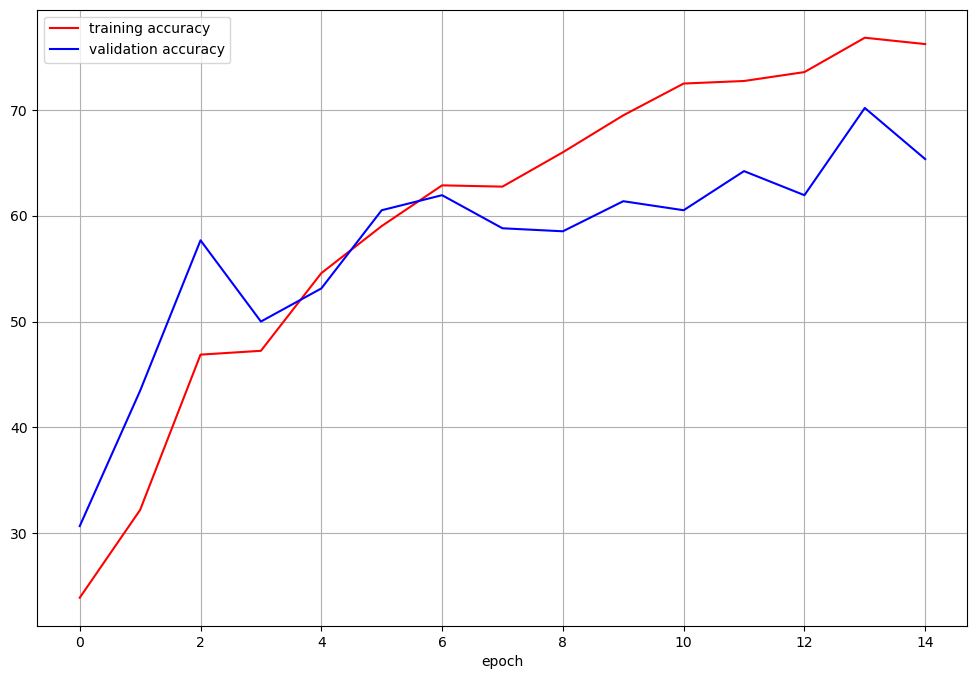

              precision    recall  f1-score   support

           0       0.55      0.57      0.56        72
           1       0.58      0.67      0.62        66
           2       0.77      0.72      0.75        79
           3       0.82      0.54      0.65        68
           4       0.57      0.69      0.63        74

    accuracy                           0.64       359
   macro avg       0.66      0.64      0.64       359
weighted avg       0.66      0.64      0.64       359



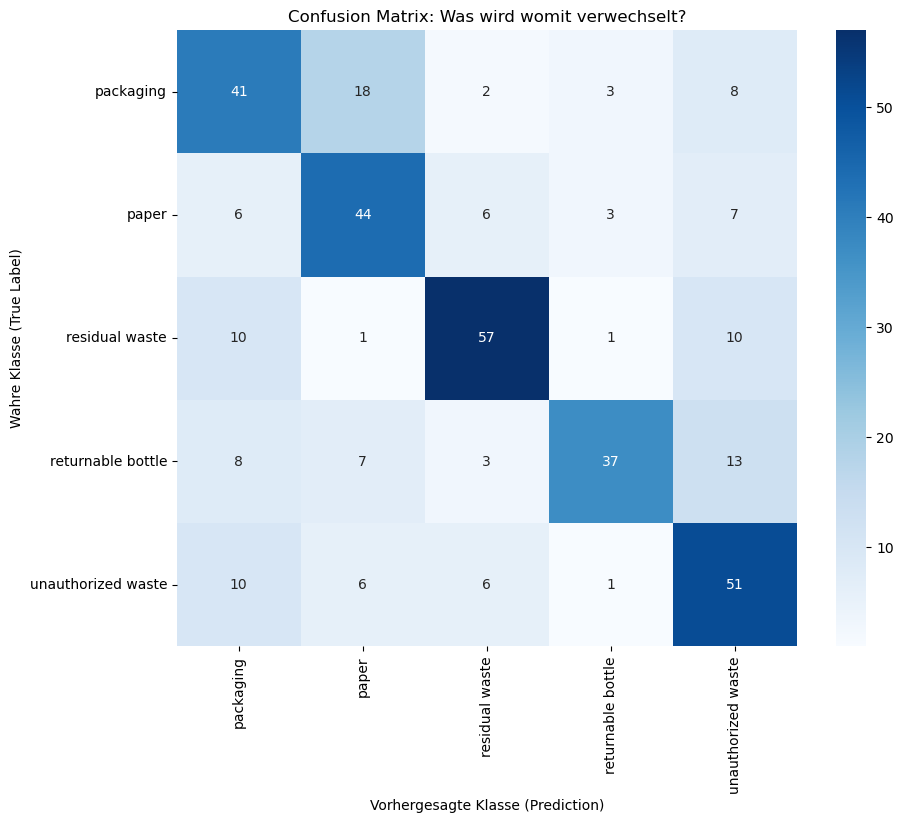

train_accuracy,▁▂▄▄▅▆▆▆▇▇▇▇███
train_loss,█▇▆▆▅▄▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▆▄▅▆▇▆▆▆▆▇▇█▇
val_loss,█▆▃▄▄▂▃▂▂▂▄▁▂▁▁
train_accuracy,76.20192
train_loss,0.71305
val_accuracy,65.34091
val_loss,1.06923


In [47]:
custom_model_pipeline("Custom Transfer Learning - Finetune", config_transfer_vgg["finetune"])

### Beschreibung und Auswertung (VGG16 - Finetune mit eigenen Daten)

Der Lernverlauf dieses Modells zeigt einen vergleichsweise volatilen Trainingsprozess, was typisch für Trainingsläufe mit einer begrenzten Datenmenge ist. Während die Trainingsaccuracy von anfänglich etwa 24% kontinuierlich auf rund 76,2 % in der letzten Epoche ansteigt, verhält sich die Validierungsaccuracy deutlich instabiler. Sie erreicht zwar zwischenzeitlich Spitzenwerte von über 70% (Epoche 14), fällt zum Ende des Trainings jedoch auf etwa 65,3% zurück, was ein klares Indiz für Overfitting darstellt.

Der Classification Report weist eine Gesamtaccuracy von 0,64 aus. Besonders stabil ist die Leistung bei Klasse 2 (Restmüll), die mit einem F1-Score von 0,75 und einer Precision von 0,77 die besten Ergebnisse erzielt. Auffällig ist hingegen das Verhalten bei Klasse 3 (Pfandflaschen): Zwar ist die Precision mit 0,82 sehr hoch, der Recall liegt jedoch nur bei 0,54. Dies bedeutet, dass erkannte Pfandflaschen meist korrekt klassifiziert werden, ein großer Teil der tatsächlich vorhandenen Objekte dieser Klasse jedoch nicht erkannt wird.

In der Confusion Matrix zeigt sich, dass bei der Klasse Pfandflaschen häufige Verwechslungen mit Fremdmüll (13 Fälle) auftreten. Ein weiterer Problembereich zeigt sich bei der Unterscheidung zwischen Verpackung und Papier, wobei Verpackungen in 18 Fällen fälschlicherweise als Papier klassifiziert werden. Diese Fehler lassen sich größtenteils auf die limitierte Datenbasis zurückführen, da dem Modell nur wenige Variationen pro Klasse zur Verfügung standen, um klare visuelle Trennlinien zu erlernen.

Zusammenfassend zeigt das Modell trotz der stark reduzierten Datenmenge eine solide Grundleistung und erkennt grundlegende visuelle Muster. Die deutliche Diskrepanz zwischen Trainings- und Validierungsleistung sowie die Schwankungen in der Validierungskurve verdeutlichen jedoch, dass die eingeschränkte Datenbasis die Generalisierungsfähigkeit des Modells aktuell begrenzt.

### VGG16 - Finetune mit allen Daten

{'model_type': 'TRANSFER_VGG', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

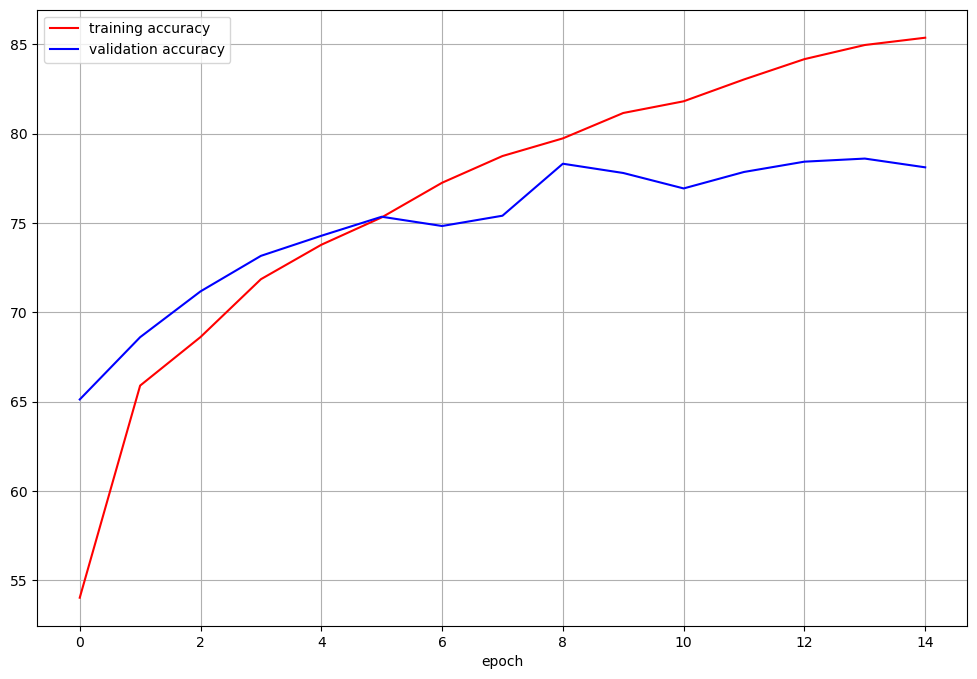

              precision    recall  f1-score   support

           0       0.70      0.75      0.73       698
           1       0.71      0.88      0.78       650
           2       0.81      0.75      0.78       723
           3       0.88      0.86      0.87       709
           4       0.82      0.66      0.73       697

    accuracy                           0.78      3477
   macro avg       0.79      0.78      0.78      3477
weighted avg       0.79      0.78      0.78      3477



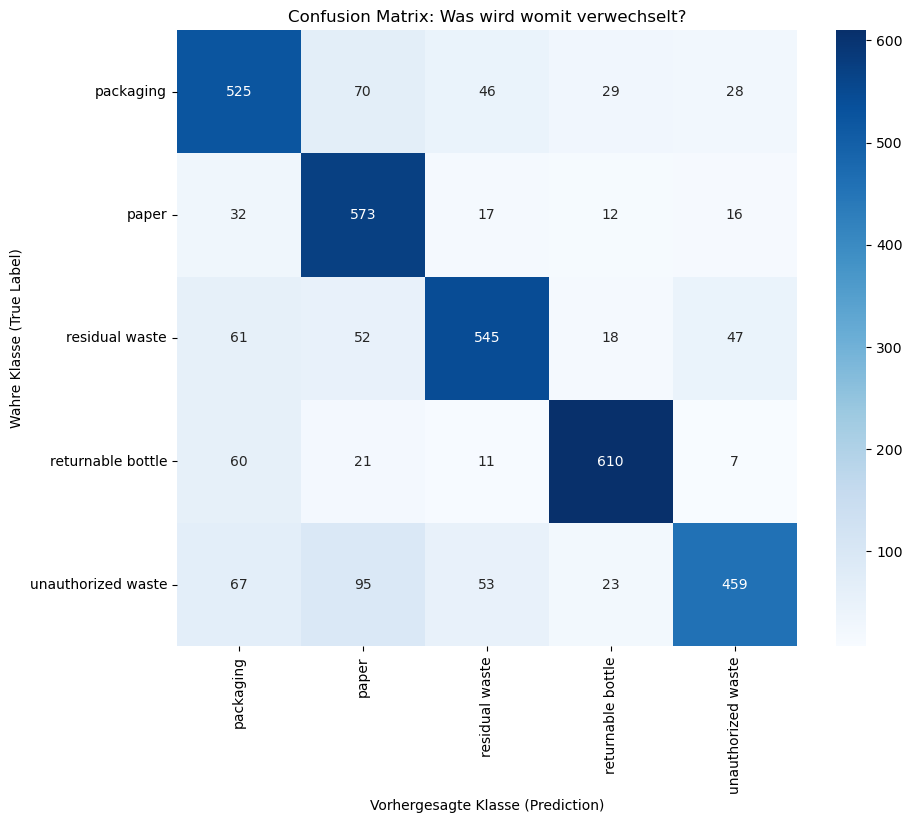

train_accuracy,▁▄▄▅▅▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆██▇████
val_loss,█▆▅▃▃▂▃▃▁▂▂▁▂▁▂
train_accuracy,85.36314
train_loss,0.42061
val_accuracy,78.1106
val_loss,0.67481


In [49]:
all_model_pipeline("Custom Transfer Learning - Finetune", config_transfer_vgg["finetune"])

### Beschreibung und Auswertung (VGG16 - Finetune mit allen Daten)

Der Lernverlauf dieses Modells zeigt eine stabile Leistung. Die Trainingsaccuracy steigt kontinuierlich an und erreicht in der letzten Epoche einen hohen Wert von rund 85,4 %. Die Validierungsaccuracy entwickelt sich ebenfalls positiv, erreicht ihren Höchstwert von etwa 78,3 % in Epoche 9 und pendelt sich zum Ende des Trainings bei rund 78,1 % ein. In Kombination mit der wachsenden Differenz zwischen Trainings- und Validierungsaccuracy deutet dies auf ein beginnendes Overfitting hin.

Der Classification Report weist eine solide Gesamtaccuracy von 0,78 aus. Besonders überzeugend ist die Leistung bei Klasse 3 (Returnable Bottle), die mit einem F1-Score von 0,87 die beste Klassifikationsqualität erreicht. Klasse 0 (Verpackungen) und Klasse 4 (Fremdmüll) schneiden mit einem F1-Score von 0,73 etwas schlechter ab.

Die Confusion Matrix liefert weitere Einblicke in die bestehenden Schwachstellen. Zwar sind die Diagonalwerte durchweg hoch, etwa 610 korrekt klassifizierte Beispiele bei Pfandflaschen und 573 bei Papier, dennoch lassen sich charakteristische Verwechslungsmuster erkennen. Besonders auffällig ist die häufige Fehlklassifikation von Fremdmüll als Papier (95 Fälle), was vermutlich auf ähnliche visuelle Eigenschaften wie Farbe oder Textur zurückzuführen ist. Darüber hinaus erweist sich die Klasse Verpackungen als vergleichsweise schwer abzugrenzen und wird häufig mit Papier (70 Fälle) verwechselt.

Zusammenfassend zeigt das Modell auf dem vollständigen Datensatz eine leistungsstarke und weitgehend stabile Klassifikationsperformance. Die wesentlichen Merkmale der einzelnen Klassen werden zuverlässig erkannt, jedoch bestehen weiterhin Unsicherheiten bei visuell ähnlichen Materialien. Das leichte Auseinanderdriften von Trainings- und Validierungsleistung deutet darauf hin, dass ohne zusätzliche Regularisierungsmaßnahmen, weiteres Training eher zu Überanpassung als zu einer verbesserten Generalisierung führen würde.

### ResNet50 - Finetune mit eigenen Daten 

{'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}


c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

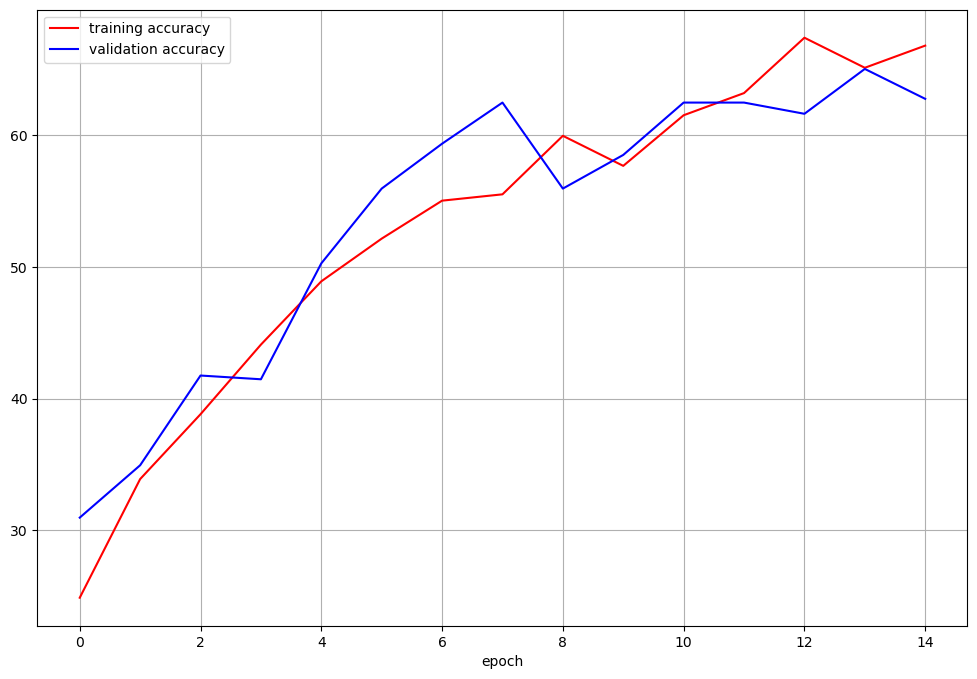

              precision    recall  f1-score   support

           0       0.61      0.47      0.53        72
           1       0.51      0.56      0.53        66
           2       0.72      0.75      0.73        79
           3       0.68      0.63      0.66        68
           4       0.56      0.65      0.60        74

    accuracy                           0.62       359
   macro avg       0.62      0.61      0.61       359
weighted avg       0.62      0.62      0.61       359



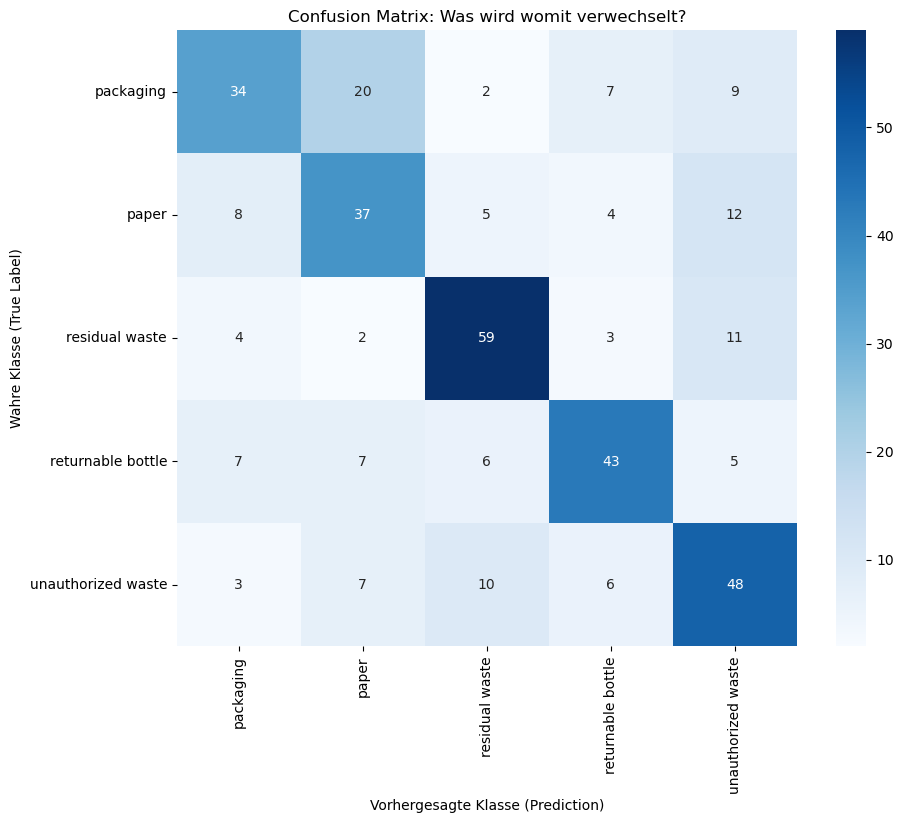

train_accuracy,▁▂▃▄▅▅▆▆▇▆▇▇███
train_loss,█▇▆▆▅▄▄▄▃▃▂▂▁▁▁
val_accuracy,▁▂▃▃▅▆▇▇▆▇▇▇▇██
val_loss,█▇▃▂▃▂▁▁▁▁▁▁▁▁▁
train_accuracy,66.82692
train_loss,0.9112
val_accuracy,62.78409
val_loss,1.06267


In [50]:
custom_model_pipeline("Custom Data Transfer Learning with ResNet50", config_transfer_rn["finetune"])

### Beschreibung und Auswertung (ResNet50 - Finetune mit eigenen Daten)

Der Trainingsverlauf des ResNet50 auf dem relativ kleinen Datensatz zeigt anfängliche Anpassungsschwierigkeiten. In den ersten Epochen sind Loss-Werte hoch (Validierung > 3,6) und die Accuracy niedrig, bevor sich das Modell ab etwa Epoche 6 zunehmend stabilisiert. Zum Ende des Trainings (Epoche 15) erreicht es eine Trainingsaccuracy von rund 66,8 % sowie eine Validierungsaccuracy von etwa 62,8 %.

Der Classification Report weist eine Gesamtaccuracy von 0,62 aus. Die beste Leistung erzielt das Modell bei Klasse 2 (Restmüll) mit einem F1-Score von 0,73. Deutlich schwächer fällt hingegen die Erkennung von Verpackungen (Klasse 0) aus, bei der der Recall mit 0,47 sehr niedrig ist. Auch bei Papier (Klasse 1) zeigt sich mit einer Precision von 0,51 eine erhöhte Fehlklassifikationsrate.

In der Confusion Matrix sieht man, dass besonders auffällig die starke Verwechslung zwischen Verpackungen und Papier ist. Zudem wird Papier mehrfach als Fremdmüll eingeordnet. Positiv hervorzuheben ist hingegen die stabile Klassifikation von Restmüll mit 59 korrekten Treffern.

Insgesamt erzielt das ResNet50 auf der kleinen Datenbasis eine solide, aber begrenzte Leistung. Die hohe Modellkomplexität erfordert offenbar mehr Trainingsdaten, um visuell ähnliche Klassen zuverlässig zu trennen. Die erreichte Accuracy von 62 % bildet eine brauchbare Grundlage, lässt jedoch deutliches Optimierungspotenzial durch zusätzliche Daten oder gezielte Regularisierung erkennen.

### ResNet50 - Finetune mit allen Daten 

{'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      Batc

c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Train Loss: 1.2925, Train Acc: 48.41%, Val Loss: 1.1747, Val Acc: 57.43%
Epoch [2/15], Train Loss: 1.1060, Train Acc: 58.49%, Val Loss: 0.9426, Val Acc: 66.45%
Epoch [3/15], Train Loss: 1.0235, Train Acc: 62.02%, Val Loss: 0.8372, Val Acc: 70.25%
Epoch [4/15], Train Loss: 0.9605, Train Acc: 64.80%, Val Loss: 0.8095, Val Acc: 70.07%
Epoch [5/15], Train Loss: 0.9405, Train Acc: 65.82%, Val Loss: 0.7449, Val Acc: 73.16%
Epoch [6/15], Train Loss: 0.8890, Train Acc: 67.12%, Val Loss: 0.7510, Val Acc: 72.47%
Epoch [7/15], Train Loss: 0.8705, Train Acc: 68.10%, Val Loss: 0.7503, Val Acc: 73.79%
Epoch [8/15], Train Loss: 0.8296, Train Acc: 69.82%, Val Loss: 0.6904, Val Acc: 75.75%
Epoch [9/15], Train Loss: 0.8018, Train Acc: 71.49%, Val Loss: 0.7130, Val Acc: 74.57%
Epoch [10/15], Train Loss: 0.7699, Train Acc: 72.65%, Val Loss: 0.6738, Val Acc: 75.43%
Epoch [11/15], Train Loss: 0.7401, Train Acc: 73.32%, Val Loss: 0.6656, Val Acc: 75.37%
Epoch [12/15], Train Loss: 0.7296, Train 

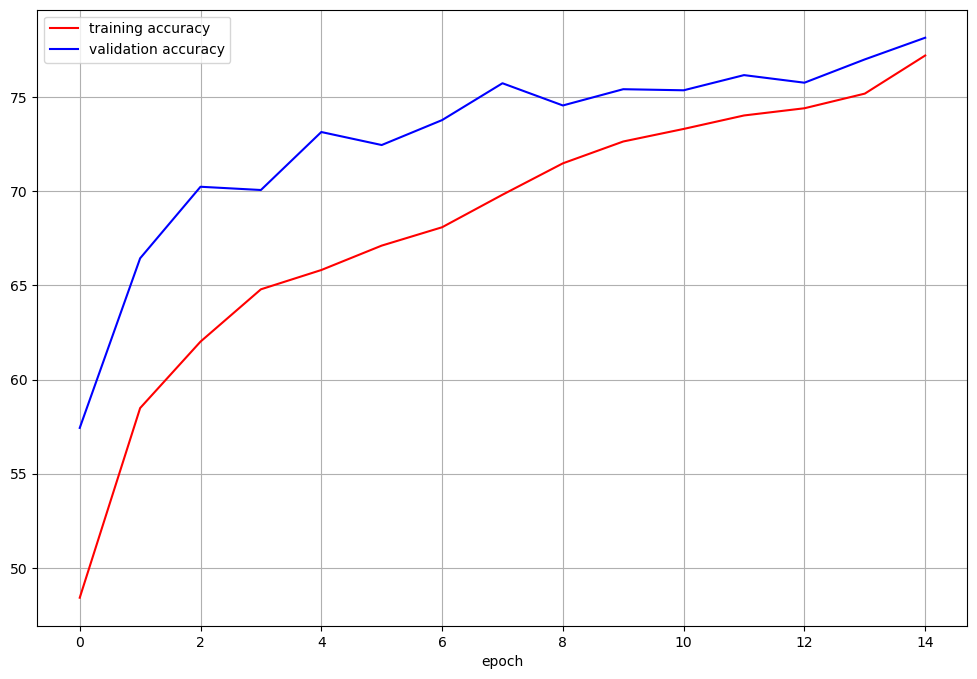

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       698
           1       0.84      0.78      0.81       650
           2       0.76      0.78      0.77       723
           3       0.81      0.90      0.85       709
           4       0.73      0.76      0.75       697

    accuracy                           0.78      3477
   macro avg       0.78      0.78      0.78      3477
weighted avg       0.78      0.78      0.78      3477



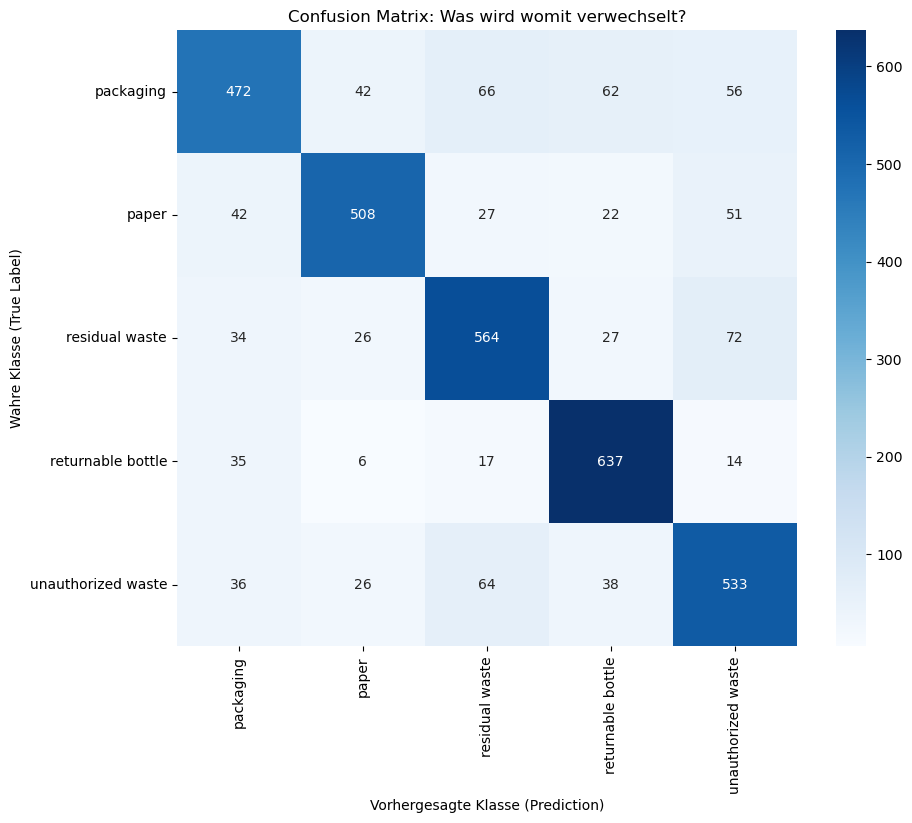

train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇██
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇██
val_loss,█▅▄▃▃▃▃▂▂▂▂▁▂▁▁
train_accuracy,77.22332
train_loss,0.6484
val_accuracy,78.1682
val_loss,0.62472


In [51]:
all_model_pipeline("All Data Transfer Learning with ResNet50", config_transfer_rn["finetune"])

### Beschreibung und Auswertung (ResNet50 - Finetune mit allen Daten)

Die Trainings- und Validierungskurven des ResNet50 Modells auf dem all-data Datensatz zeigen in den ersten drei Epochen einen starken Anstieg beider Genauigkeitswerte. Anschließend setzt sich der Anstieg bis zur vierzehnten Epoche fort, jedoch mit flacherem Verlauf. Am Ende des Trainings erreicht das Modell eine Trainingsaccuracy von 77,22 % sowie eine Validierungsaccuracy von 78,17 %. In den ersten acht Epochen liegen die Validierungswerte zeitweise bis zu 5 % über den Trainingswerten. Gegen Ende des Trainings nähern sich beide Kurven deutlich an, wodurch anfänglich leichtes Overfitting reduziert wird.

Der Classification Report zeigt, dass die Klasse Pfandflaschen mit einem F1 Score von 0.85 die höchste Erkennungsleistung erreicht. Die Klasse Verpackungen weist mit einem F1 Score von 0.72 die geringste Leistung auf. Insgesamt zeigen die Metriken eine robuste Klassifikationsleistung mit ausgewogener Precision und Recall über alle Klassen hinweg.

Die Confusion Matrix bestätigt die Validierungsaccuracy von rund 78 % durch eine deutlich ausgeprägte Hauptdiagonale. Besonders zuverlässig wird die Klasse Pfandflaschen erkannt, wobei 637 Bilder korrekt klassifiziert werden. Die häufigste Fehlklassifikation tritt zwischen Restmüll und Fremdmüll auf. Zudem zeigt die Klasse Verpackungen vermehrt Verwechslungen mit den Klassen Restmüll, Pfandflaschen und Fremdmüll.

Das ResNet50 Modell zeigt eine stabile Trainingsdynamik und eine solide Generalisierungsleistung. Während klar unterscheidbare Klassen wie Pfandflaschen sehr zuverlässig erkannt werden, bestehen weiterhin Unsicherheiten bei visuell ähnlichen Kategorien wie Verpackungen und Restmüll. Eine Erweiterung des Datensatzes oder eine stärkere Trennung der Klassenmerkmale könnte die Leistung in diesen Bereichen weiter verbessern.

### ResNet50 - Finetune mit externen Daten 

Running model pipeline: Extern Data Transfer Learning with ResNet50, with config: {'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}
{'model_type': 'TRANSFER_RN', 'model_subtype': 'TRAIN_FINETUNE', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 15, 'hidden_dim': 128, 'dropout': 0.2}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8       

c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows 11 Pro\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Train Loss: 1.2749, Train Acc: 48.58%, Val Loss: 0.9711, Val Acc: 63.72%
Epoch [2/15], Train Loss: 1.0317, Train Acc: 61.44%, Val Loss: 0.8586, Val Acc: 69.01%
Epoch [3/15], Train Loss: 0.9434, Train Acc: 65.13%, Val Loss: 0.7647, Val Acc: 72.49%
Epoch [4/15], Train Loss: 0.8892, Train Acc: 67.41%, Val Loss: 0.7477, Val Acc: 74.84%
Epoch [5/15], Train Loss: 0.8534, Train Acc: 68.58%, Val Loss: 0.6722, Val Acc: 76.39%
Epoch [6/15], Train Loss: 0.7997, Train Acc: 71.41%, Val Loss: 0.6798, Val Acc: 75.93%
Epoch [7/15], Train Loss: 0.7687, Train Acc: 72.67%, Val Loss: 0.6310, Val Acc: 78.19%
Epoch [8/15], Train Loss: 0.7681, Train Acc: 72.10%, Val Loss: 0.6750, Val Acc: 76.13%
Epoch [9/15], Train Loss: 0.7149, Train Acc: 74.05%, Val Loss: 0.6443, Val Acc: 76.64%
Epoch [10/15], Train Loss: 0.6974, Train Acc: 75.39%, Val Loss: 0.6220, Val Acc: 79.74%
Epoch [11/15], Train Loss: 0.6670, Train Acc: 75.65%, Val Loss: 0.6322, Val Acc: 77.64%
Epoch [12/15], Train Loss: 0.6396, Train 

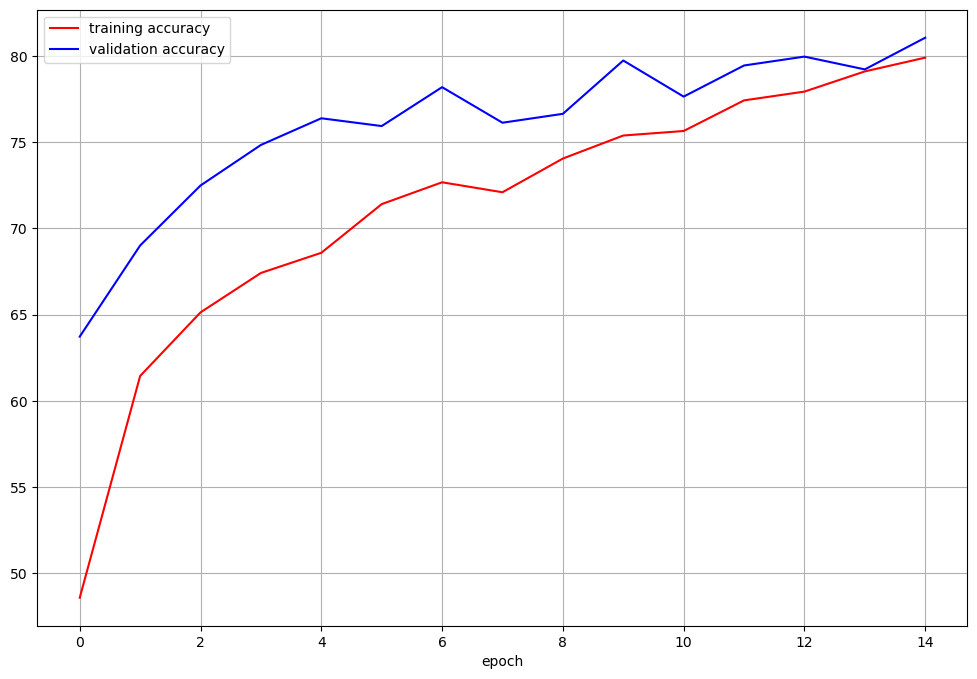

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       661
           1       0.81      0.87      0.84       565
           2       0.80      0.79      0.80       721
           3       0.87      0.88      0.87       580
           4       0.74      0.79      0.77       591

    accuracy                           0.81      3118
   macro avg       0.81      0.81      0.81      3118
weighted avg       0.81      0.81      0.81      3118



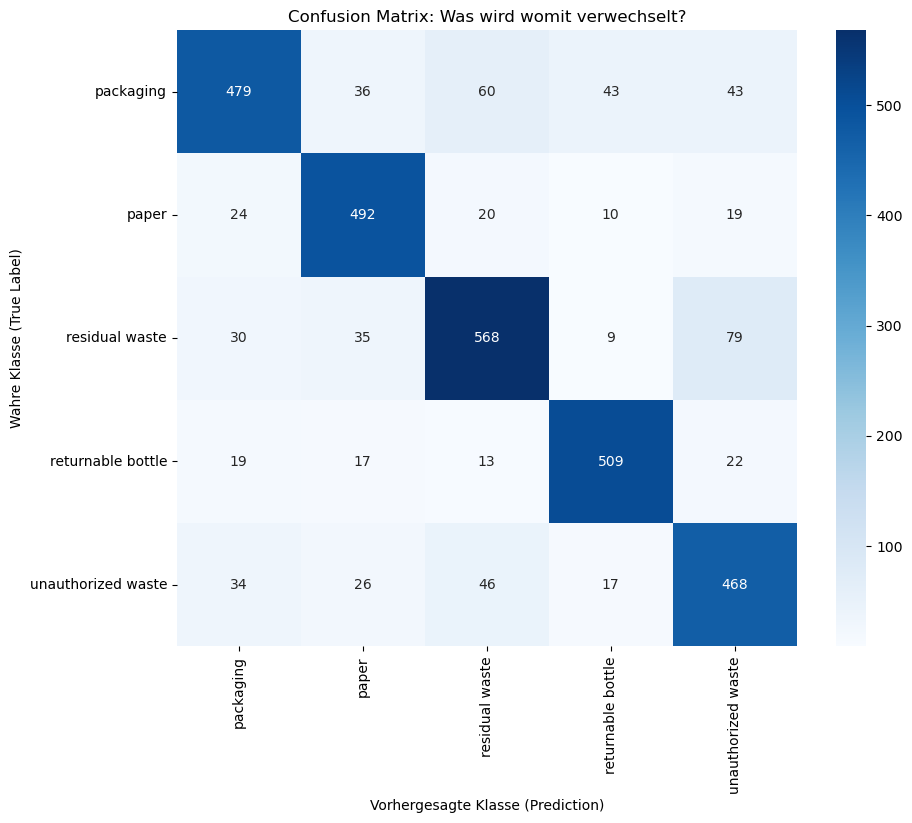

train_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▆▇▆▆▇▇▇█▇█
val_loss,█▆▅▄▃▃▂▃▃▂▂▂▁▂▁
train_accuracy,79.90088
train_loss,0.57592
val_accuracy,81.0567
val_loss,0.55481


In [52]:
extern_model_pipeline("Extern Data Transfer Learning with ResNet50", config_transfer_rn["finetune"])

### Beschreibung und Auswertung (ResNet50 - Finetune mit externen Daten)

Die Trainings und Validierungskurven des ResNet50 Modells auf dem external-data Datensatz zeigen über alle Epochen hinweg einen stetigen Anstieg. Zu Beginn liegt die Trainingsaccuracy deutlich unter der Validierungsaccuracy. Dieser Abstand verringert sich im Verlauf des Trainings kontinuierlich, sodass am Ende nur noch eine Differenz von rund 1 % besteht. Das Modell erreicht schließlich eine Trainingsaccuracy von 79,90 % sowie eine Validierungsaccuracy von 81,06 %. Dies deutet auf eine stabile Konvergenz und eine gute Generalisierungsfähigkeit hin.

Der Classification Report bestätigt die hohe Gesamtleistung mit einer Accuracy von 81 %. Auf Klassenebene wird die Kategorie Pfandflaschen mit einem F1 Score von 0.87 am zuverlässigsten erkannt. Auch Papier und Restmüll erreichen mit F1 Scores von 0.84 und 0.80 sehr gute Ergebnisse. Verpackungen und Fremdmüll liegen mit F1 Scores von jeweils 0.77 etwas darunter, verbleiben jedoch auf einem stabilen Leistungsniveau.

Die Confusion Matrix verdeutlicht die Verteilung der richtigen und falschen Klassifikationen. Die Klasse Restmüll weist mit 568 korrekt erkannten Bildern die höchste Anzahl richtiger Zuordnungen auf. Gleichzeitig treten hier mit 79 Verwechslungen zur Klasse Fremdmüll die häufigsten Fehlklassifikationen auf. Weitere nennenswerte Verwechslungen zeigen sich bei Verpackungen mit Restmüll (Wert: 60). Die geringste Fehlklassifikation tritt zwischen Restmüll und Pfandflaschen mit dem Wert 9 auf.

Das ResNet50 Modell mit Fine Tuning auf den externen Daten erreicht eine hohe und stabile Gesamtleistung mit guter Generalisierung. Besonders klar unterscheidbare Klassen wie Pfandflaschen werden sehr zuverlässig erkannt. Verwechslungen treten überwiegend zwischen visuell ähnlichen Kategorien wie Restmüll und Fremdmüll sowie bei Verpackungen auf, was auf weiterhin vorhandene Überschneidungen in den Bildmerkmalen hinweist.

## 5.3. Hyperparameroptimierung mit Weights and Bias

Die folgende Funktion dient der Auswahl eines Modells mit hoher Generalisierungsfähigkeit.
Hierzu werden sowohl die Validation Accuracy als auch die Train Accuracy berücksichtigt und durch eine Strafterm-gewichtete Differenz beider Werte ergänzt. Dadurch werden Modelle mit starkem Overfitting systematisch benachteiligt.
Eine ausschließliche Auswahl anhand der Validation Accuracy ist nicht ausreichend, da sie keine Aussage über die Stabilität und Übertragbarkeit des Modells auf unbekannte Daten erlaubt.

In [58]:
async def get_best_generalizing_run(
    runs,
    val_key="val_accuracy",
    test_key="train_accuracy",
    overfit_weight=1.0
):  
    best_run = None
    best_score = float("-inf")

    for run in runs:
        val_acc = run.summary.get(val_key)
        test_acc = run.summary.get(test_key)
 
        if val_acc is None or test_acc is None:
            continue

        overfit_gap = abs(val_acc - test_acc)
        score = val_acc + test_acc - overfit_weight * overfit_gap

        if score > best_score:
            best_score = score
            best_run = run

    return best_run


Ziel dieses Kapitels ist es geeignete Kombinationen zentraler Trainingsparameter effizient zu identifizieren und deren Einfluss auf die Modellperformance nachvollziehbar zu analysieren. Hierzu verwenden wir den Weights and Biases Agent um einen automatisierten Workflow zu ermöglichen. Die Hyperparameteroptimierung wurde ausschließlich für die selbst entwickelten MLP- und CNN-Modelle durchgeführt, da diese vollständig neu trainiert werden und somit stark von der Wahl der Hyperparameter abhängen. Die eingesetzten Transfer-Learning-Modelle verwenden hingegen einen einfachen und bereits auf die jeweilige Architektur abgestimmten Classifier, wodurch eine seperate Hyperparametisierung in diesem Kontext nicht weiter zielführend wäre.

#### 5.3.1. MLP - Hyperparameroptimierung

Als erstes Basismodell wurde ein Multilayer Perceptron (MLP) eingesetzt, da es vollständig trainierbar ist und sich gut zur Analyse des Einflusses zentraler Hyperparameter eignet.
Zunächst wird der Hyperparameter-Suchraum für das MLP definiert, der feste Trainingsparameter sowie variierende Werte für Lernrate, versteckte Dimensionen und Dropout umfasst.

In [53]:
parameters_mlp = { 
    'model_type': {
        'value': 'MLP'},
    'epochs': {
        'value': 15}, 
    'batch_size': {
        'value': 16},
    'learning_rate': {
        'values': [0.005,0.01,0.1]},  
    'hidden_dim': {
        'values': [32,64,128,256,512]}, 
    'dropout': {
        'values': [0.0,0.1,0.2,0.3,0.4]}
    }

Anschließend wird eine Sweep-Konfiguration mit zufälliger Stichprobenstrategie erstellt und bei Weights and Biases registriert.

In [54]:
sweep_config = {
    "method" : "random",
    "parameters" : parameters_mlp
} 

In [55]:
sweep_id=wandb.sweep(sweep_config,project=WANDB_PROJECT)

Create sweep with ID: mxn7iaj8
Sweep URL: https://wandb.ai/sltai/M%C3%BCll%20Klassifikation/sweeps/mxn7iaj8


Über einen Sweep-Agenten werden mehrere Trainingsläufe automatisiert ausgeführt, wobei jede Konfiguration evaluiert wird.

In [ ]:
wandb.agent(sweep_id, function=lambda: extern_model_pipeline("MLP"), count=10)

Nach Abschluss der definierten Anzahl an Runs wird die Verbindung zu Weights and Biases ordnungsgemäß beendet.

In [57]:
wandb.teardown()

Auf Basis dieser Runs wird das Modell mit der besten Generalisierungsfähigkeit bestimmt.

In [60]:
api = wandb.Api()
sweep = api.sweep(f'sltai/Müll Klassifikation/sweeps/{sweep_id}')

In [61]:
best_run = await get_best_generalizing_run(sweep.runs)

print(
        f"Best run: {best_run.name}\n"
        f"Validation Accuracy: {best_run.summary['val_accuracy']:.2f}%\n"
        f"Training Accuracy: {best_run.summary['train_accuracy']:.2f}%\n"
        f"Overfitting Gap: "
        f"{abs(best_run.summary['val_accuracy'] - best_run.summary['train_accuracy']):.2f}%"
    )

Best run: bright-sweep-8
Validation Accuracy: 49.97%
Training Accuracy: 51.10%
Overfitting Gap: 1.13%


In [62]:
best_run.config

{'epochs': 15,
 'dropout': 0.2,
 'batch_size': 16,
 'hidden_dim': 256,
 'model_type': 'MLP',
 'learning_rate': 0.01}

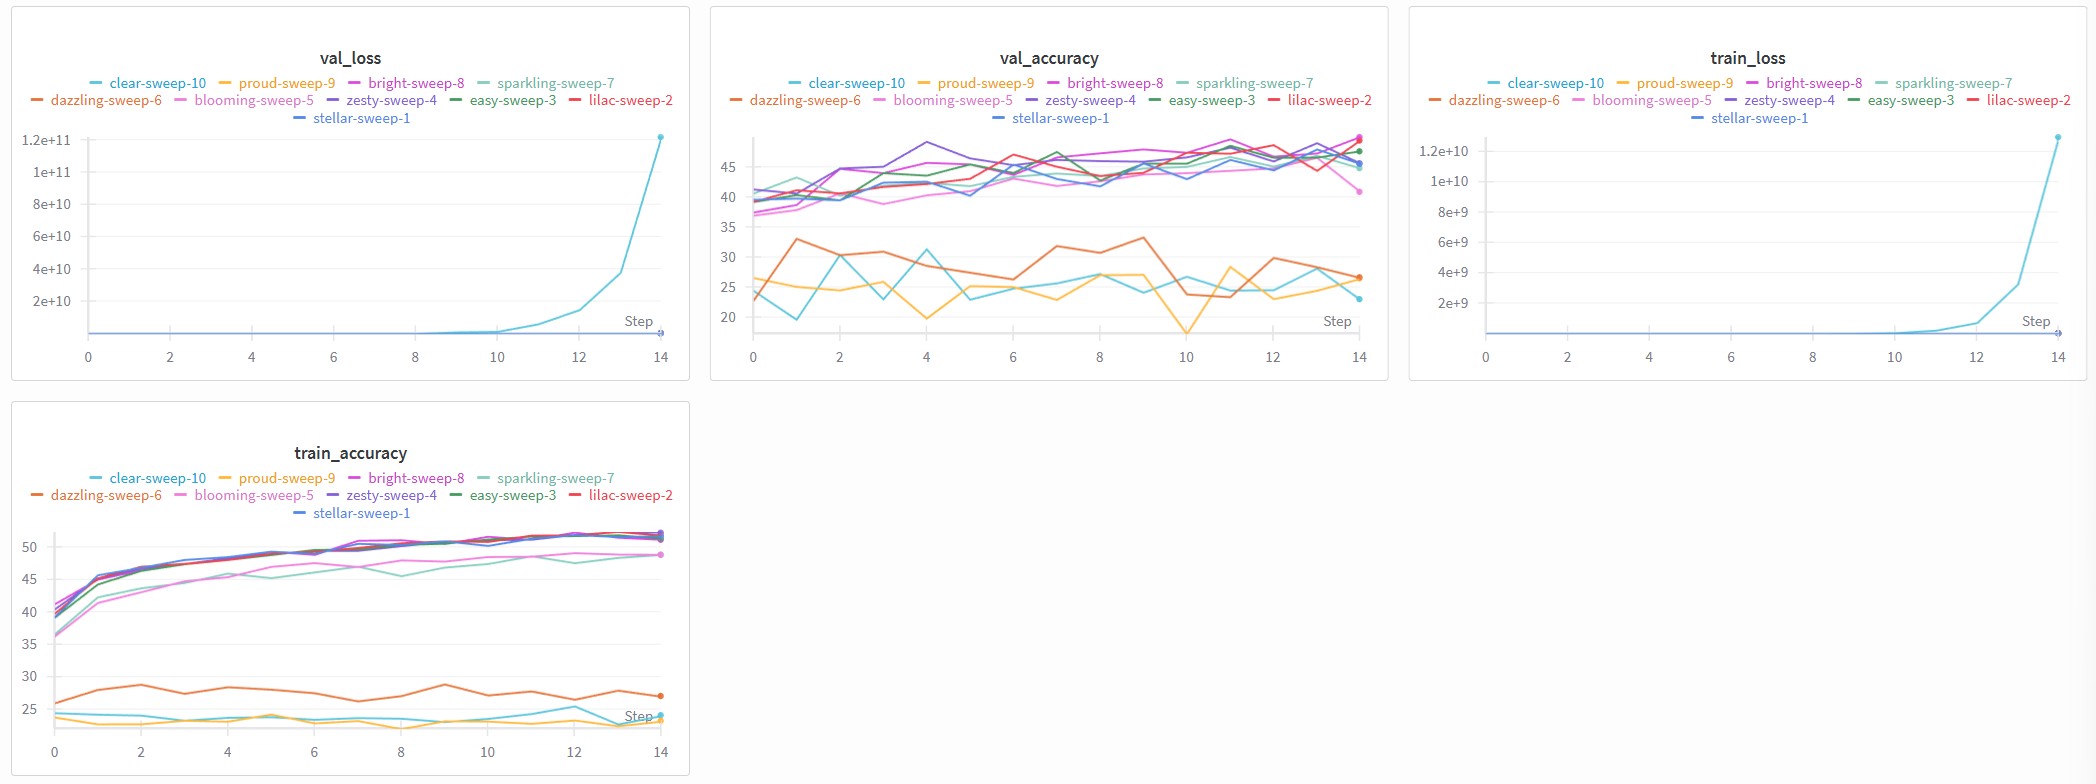

Bei der Auswertung der MLP-Trainingsläufe traten einzelne Konfigurationen auf, bei denen der Loss bereits nach wenigen Epochen extrem anstieg. Diese Runs verwendeten eine sehr hohe Lernrate von 0.1, was zu instabilen Gewichtsanpassungen führte.

Aufgrund dieser stark abweichenden Skalen verzerrten die betroffenen Runs die Darstellung des gesamten Experiments, wodurch der tatsächliche Loss-Verlauf der stabilen Modelle kaum bzw. garnicht erkennbar wurde. Aus diesem Grund wurden diese Runs in der folgenden Darstellung ausgeblendet.

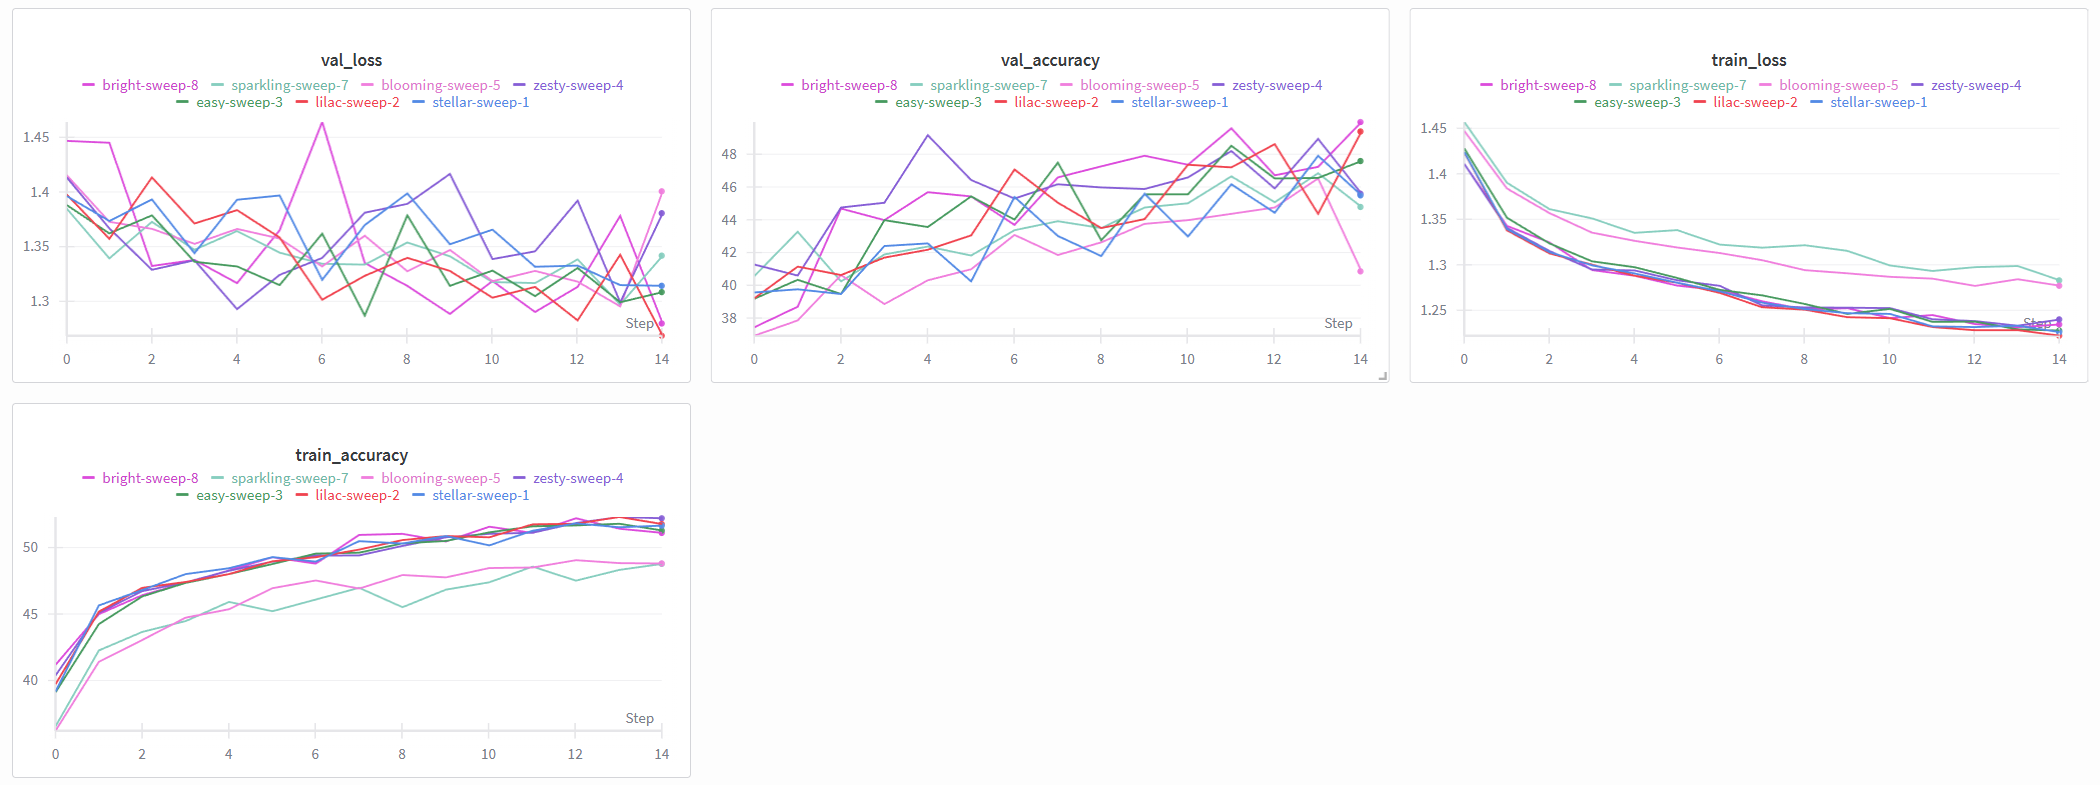

Die Ergebnisse der Hyperparameteroptimierung zeigen, dass sich die Trainings- und Validierungsgenauigkeiten über die meisten Runs hinweg stabil entwickeln, während einzelne Konfigurationen zu stark ansteigenden Fehlerraten führen. Insbesondere lässt sich erkennen, dass die Kombination aus zu hoher Lernrate und größerer Modellkapazität zu einer höheren Divergenz von Trainings- und Validierungs-Loss führen.
<br><br>
Der bestgeeigneteste Durchlauf wurde als Run `bright-sweep-8` identifiziert, der eine Validation Accuracy von 49,97% und eine Trainings Accuracy von 51,10% bei einer sehr geringen Overfitting-Gap von 1,13% zeigt. 
Die Runs mit dauerhaft niedriger Trainings- und Validierungsgenauigkeit lassen sich auf eine zu hoch gewählte Lernrate zurückführen, wodurch das Modell nicht effektiv lernt und die Accuracy über die Trainingsdurchläufe hinweg auf einem niedrigen Niveau verharrt.
<br><br>
Insgesamt zeigt sich, dass moderate Lernraten sowie mittlere hidden Dimensions zu stabilen und gut generalisierenden Modellen führen.

#### 5.3.2. CNN - Hyperparameroptimierung
Die Hyperparameteroptimierung für das Convolutional Neural Network (CNN) folgt demselben methodischen Vorgehen wie zuvor für das MLP beschrieben. Entsprechend werden erneut ein zufälliger Hyperparameter-Sweep mit Weights and Biases definiert und mehrere Trainingsläufe automatisiert ausgeführt.

In [61]:
parameters_cnn = { 
    'model_type': {
        'value': 'CNN'},
    'epochs': {
        'value': 15}, 
    'batch_size': {
        'value': 16},
    'learning_rate': {
        'values': [0.005,0.01,0.1]},  
    'hidden_dim_1': {
        'values': [32,64,128,256,512,1024]}, 
    'dropout': {
        'values': [0.0,0.1,0.2,0.3,0.4]}
    }

In [62]:
sweep_config = {
    "method" : "random",
    "parameters" : parameters_cnn
} 

In [63]:
sweep_id=wandb.sweep(sweep_config,project=WANDB_PROJECT)

Create sweep with ID: vbl9r5v8
Sweep URL: https://wandb.ai/sltai/M%C3%BCll%20Klassifikation/sweeps/vbl9r5v8


In [ ]:
wandb.agent(sweep_id, function=lambda: extern_model_pipeline("CNN"), count=10)

In [ ]:
wandb.teardown()

In [64]:
api = wandb.Api()
sweep = api.sweep(f'sltai/Müll Klassifikation/sweeps/{sweep_id}')

In [65]:
best_run = await get_best_generalizing_run(sweep.runs)

print(
        f"Best run: {best_run.name}\n"
        f"Validation Accuracy: {best_run.summary['val_accuracy']:.2f}%\n"
        f"Train Accuracy: {best_run.summary['train_accuracy']:.2f}%\n"
        f"Overfitting Gap: "
        f"{abs(best_run.summary['val_accuracy'] - best_run.summary['train_accuracy']):.2f}%"
    )

Best run: generous-sweep-3
Validation Accuracy: 69.97%
Train Accuracy: 68.82%
Overfitting Gap: 1.16%


In [66]:
best_run.config

{'epochs': 15,
 'dropout': 0,
 'batch_size': 16,
 'model_type': 'CNN',
 'hidden_dim_1': 256,
 'learning_rate': 0.005}

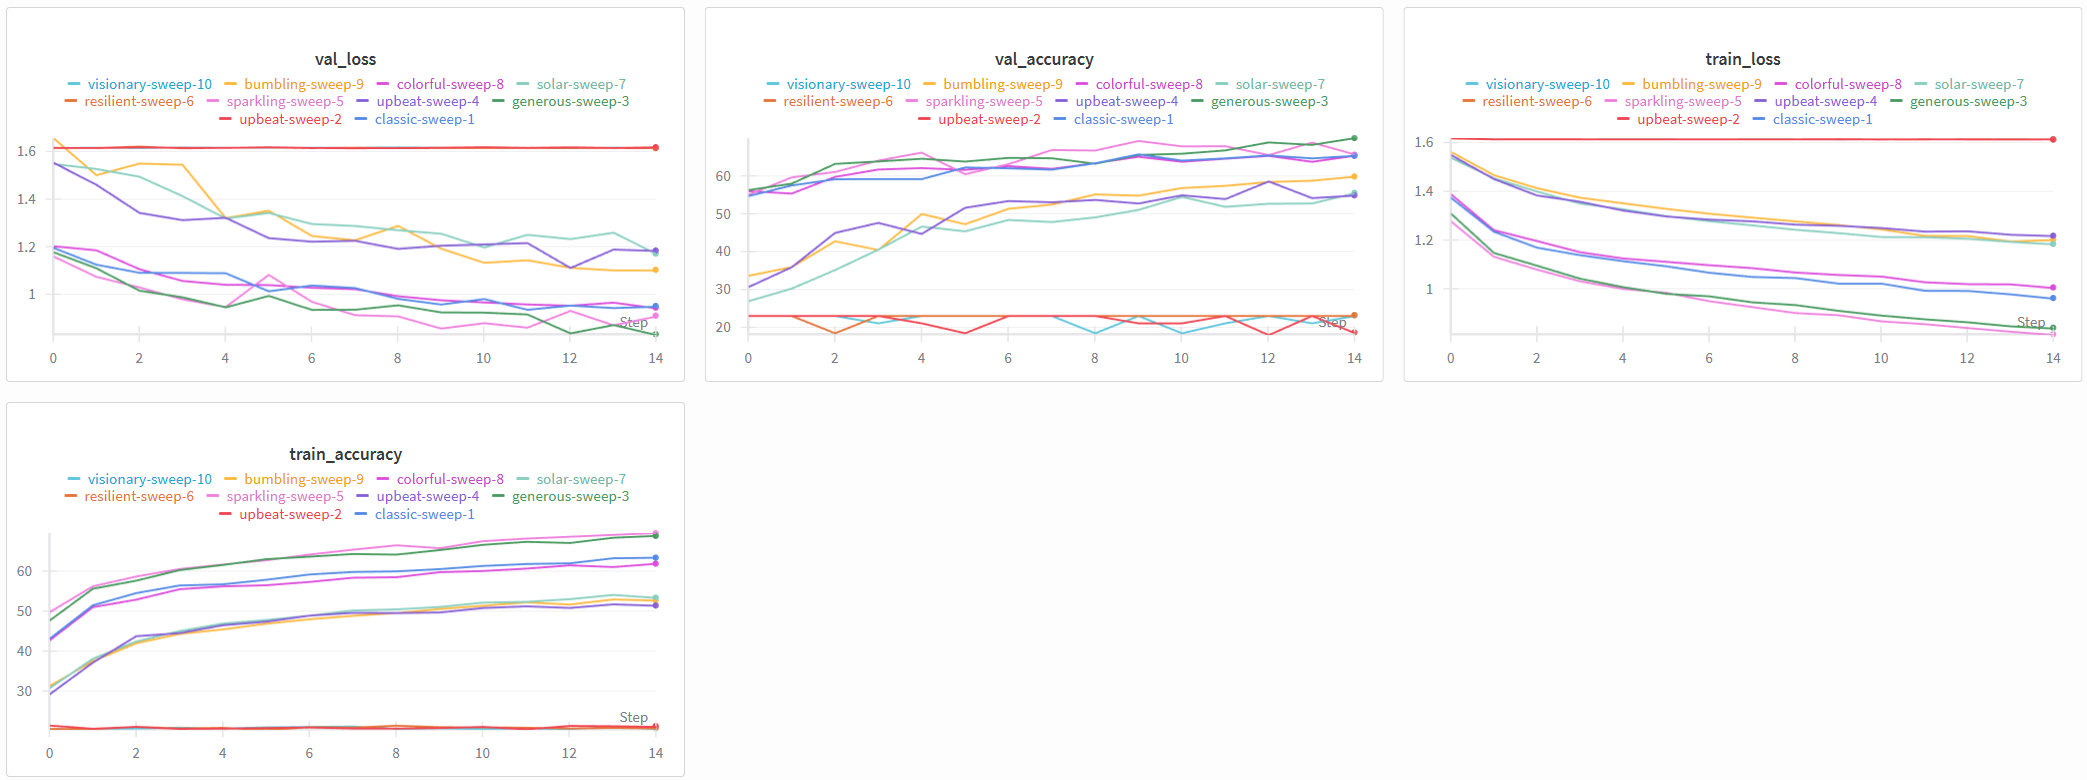

Beim CNN Modell wurde der Run `generous-sweep-3` als leistungsstärkstes Modell identifiziert und erreichte eine Validation Accuracy von 69,97% sowie eine Trainings Accuracy von 68,82%. Das geringe Overfitting von 1,16% weist auf eine stabile Generalisierungsfähigkeit hin und zeigt, dass das Modell weder stark- noch überangepasst ist.

Auch beim CNN kann man Konfigurationen mit sehr hoher Lernrate beobachten, die keine sinnvolle Modellkonvergenz erreichten. Im Gegensatz zum MLP zeigt sich hier jedoch kein überproportionaler Anstieg des Loss, sondern ein nahezu konstant gleichbleibender Verlauf, was auf ein instabiles Optimierungsverfahren und effektives Underfitting hinweist. Die hohe Lernrate verhindert also in diesem Fall die Schrittweise Ausbildung aussagekräftiger Merkmale.

In [65]:
wandb.finish()

## 6. Fazit <a id="fazit"></a>

Im Rahmen dieser Arbeit wurden verschiedene Modellarchitekturen und Trainingsstrategien systematisch untersucht, um die Leistungsfähigkeit unterschiedlicher Ansätze für die Bildklassifikation von Abfallkategorien zu vergleichen. Die durchgeführten Experimente liefern eine fundierte Grundlage, um die eingangs formulierten Forschungsfragen gezielt zu beantworten. Im folgenden Abschnitt werden diese Fragen aufgegriffen und auf Basis der erzielten Ergebnisse konkret beantwortet.

#### Welche Unterschiede in der Modellleistung zeigen sich zwischen einem selbst entwickelten CNN und Transfer Learning Architekturen?

Bezogen auf unsere Ergebnisse lassen sich die Unterschiede in der Modelleistung klar zwischen unserem selbst entwickelten CNN und einer Transfer-Learning-Architektur herausarbeiten. 
Das CNN zeigt eine nur begrenzte Modelleistung. Mit einer Trainingsgenauigkeit von 66,3% und einer Validierungsgenauigkeit von 63,46% lernt das Modell zwar grundlegende Strukturen, erreicht jedoch keine hohe Trennschärfe zwischen den Klassen. Die Lernkurve steigt langsam an und flacht früh ab, was darauf hindeutet, dass das Modell nicht ausreichend robuste visuelle Merkmale extrahieren und erlernen kann. Dies zeigt sich ebenfalls in der Confusion Matrix. Ähnliche Abfallklassen werden häufig miteinander verwechselt.

Die Transfer-Learning-Architekturen zeigen dagegen eine deutlich verbesserte Modellleistung. Bereits VGG16 from Scratch profitiert von dem tieferen Feature Extractor und erreicht höhere Genauigkeiten ( Train: 77,5% und Validation: 73,3% ), was zeigt, dass komplexere Netzwerke feinere Bildmerkmale erfassen können.

Der entscheidende Unterschied zeigt sich nochmal deutlicher beim finetuned VGG16 Modell, das durch gezieltes Nachtrainieren auf die eigenen Klassen, die Leistung deutlich auf 87,5% Trainingsgenauigkeit und 81,7% Validierungsgenauigkeit steigert. Das Modell kombiniert allgemeine, vortrainierte Bildmerkmale mit spezifischen Merkmalen unserer Daten und erzielt dadurch eine wesentliche Generalisierung und Klassentrennung. Ein ähnliches Bild zeigt sich beim finetuned ResNet50. Mit 79,9% Trainings- und 81% Validierungsgenauigkeit erreicht das Modell ebenfalls eine stabile und ausgewogene Performance. Die sogar noch geringere Differenz zwischen Trainings- und Validierungsgenauigkeit, deutet zusätzlich auf eine bessere Generalisierungsfähigkeit hin, welche auf die Residual-Verbindungen im ResNet50 zurückzuführen ist.



#### Wie wirkt sich die Kombination aus externen und selbst aufgenommenen Bilddaten auf die Erkennungsleistung aus?

Die Kombination aus unseren externen und selbst aufgenommen Daten verbessert die Erkennungsleistung nicht automatisch. In unserem Experiment führt sie sogar zu einer kleinen Verschlechterung der Validierungsgenauigkeit gegenüber externen Daten allein. Beim finetuned ResNet50 erreicht das Training mit externen Daten eine Validierungsgenauigkeit von 81% während die Kombination aus externen und eigenen Bildern (all-Data) nur 78,1% erzielt. Ein vergleichbares Muster zeigt sich beim finetuned VGG16, bei dem die Validierungsleistung von 81,7% bei externen Daten ebenfalls höher ausfällt als beim Training mit der der kombinierten Datenbasis, die nur 78,1% erzielt.
Damit ist in beiden Fällen ein konsistenter Leistungsabfall bei einer Kombination der Datensätze zu beobachten.

Da wir in unseren selbst aufgenommen Bildern bewusst auf Unterschiede in Beleuchtung, Kameraperspektive, Bildqualität oder Hintergrund geachtet haben, kann es dazu führen, dass das Modell widersprüchliche visuelle Muster erlernt und Entscheidungsgrenzen kleiner werden. Ein wesentlicher Aspekt in diesem Zusammenhang ist außerdem, dass sowohl VGG16 als auch ResNet50 ursprünglich auf einem großen, allgemeinen Datensatz mit vollständig anderen Klassen vortrainiert wurde und nicht die generischen Bildmerkmale wie Kanten, Texturen und Formen aus unserer Daten gelernt hat, was zu konkurrierenden Anpassungsprozessen führen kann.

Die Ergebnisse zeigen deutlich, wie sensibel Transfer-Learning-Modelle auf völlig andere Klassen und Domänenunterschiede reagiert.


#### Welche Kategorien werden am häufigsten falsch klassifiziert und welche Ursachen lassen sich dafür aus den Konfusionsmatrizen ableiten?

Schaut man sich die Konfusionsmatrizen an, zeigt sich über alle betrachteten Modelle hinweg ein Fehlklassifikationsmuster. Am häufigsten falsch klassifiert werden die Kategorien Verpackungen, Papier und Restmüll. Insbesondere besteht eine starke gegenseitige Verwechslung zwischen der Klasse Verpackungen und Papier. Diese Fehlklassifikationen treten sowohl beim eigenen CNN als auch bei den Transfer-Learning-Modellen (VGG16 und ResNet50) auf. Die Ursache liegt in den ähnlichen visuellen Eigenschaften dieser beiden Klassen. Beide bestehen häufig aus flachen Materialien mit vergleichbaren Farben und Oberflächenstrukturen, was die visuelle Trennung, insbesondere bei teilweise verdeckten Objekten erschwert.

Eine weitere auffällige Fehlerquelle ist die Klasse Restmüll, die häufig mit der Klasse Fremdmüll verwechselt wird. Im Gegensatz zu den anderen Kategorien stellt der Fremdmüll eher eine Sammel- bzw Restkategorie dar, die visuell sehr heterogene Abfallarten umfasst. Die Fehlklassifikation der Klasse Restmüll lässt sich dadurch erklären, dass zum Beispiel Bioabfälle in realen Szenarien stark variieren und häufig keine klar definierten, konsistenten visuelle Merkmale besitzen.

Das Verhalten des MLP-Modells ist besonders auffällig, bei dem viele Klassen in Richtung einzelner dominanter Kategorien fehlklassifiziert werden. Nahezu alle Klassen, insbesondere die Klassen Verpackungen, Papier, Restmüll und Fremdmüll werden fälschlich als Pfandflaschen klassifiziert. Dies verdeutlich, dass ein MLP ohne Convolutional Layer keine räumliche Zusammenhänge erfassen kann und daher nur sehr eingeschränkt für Bildklassifikation geeignet ist. Die Dominanz der Klasse returnabe bottle lässt darauf schließen, dass diese Klasse im Trainingsdatensatz visuell deutlich konsistenter ist und das MLP diese dadurch als "einfachste" Entscheidungsoption nutzt.

## 7. Quellen <a id="quellen"></a>

[1] ALBA und Civey, "Gut gemeint: Große Mehrheit trennt den Müll und schadet dennoch dem Klima", Pressemitteilung, 20.07.2022. (Online). Verfügbar: https://www.alba.info/unternehmen/newsroom/pressemitteilungen/detail/gut-gemeint-grosse-mehrheit-trennt-den-muell-und-schadet-dennoch-dem-klima/. (Zugriff: 10.01.2026).

[2] L. Löwe, "Alles durcheinander: Die Unlust beim Mülltrennen", FR.de, 10.01.2019. (Online). Verfügbar: https://www.fr.de/ratgeber/wohnen/alles-durcheinander-unlust-beim-muelltrennen-11106084.html. (Zugriff: 15.01.2026). 

[3] Torchvision, "torchvision.models.vgg16", PyTorch Vision Models, 2025. (Online). Verfügbar: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html. (Zugriff: 27.01.2026).